In [2]:
!pip install pandas-gbq

     |████████████████████████████████| 172 kB 56.3 MB/s            


In [319]:
import pandas as pd
import json

In [320]:
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [476]:
jobs_query = """
        select
         job_id,
         organization,
         city_id,
         area,
         category_id,
         CASE WHEN english = 'No English' THEN 0
               WHEN english = 'Thoda English' THEN 1
               WHEN english = 'Basic English' THEN 2
               WHEN english = 'Good English' THEN 3
               WHEN english = 'Fluent English' THEN 4 END english_id,
         education_id,
         experience_level_id,
         leads_count,
         applicant_location,
         CASE WHEN applicant_location = "WITHIN_5KM" THEN 1
              WHEN applicant_location = "WITHIN_10KM" THEN 2
              WHEN applicant_location = "WITHIN_25KM" THEN 3
              WHEN applicant_location = "SAME_CITY" THEN 4
              WHEN applicant_location = "ANYWHERE" THEN 5 END applicant_loc_ord,
         max_salary,
         min_salary,
         is_deposit,
         num_of_skills,
         num_of_asset,
         shift,
         is_part_time,
         case when gender = 'm' then TRUE else FALSE end is_male,
         case when gender = 'f' then TRUE else FALSE end is_female,
         case when gender is null then TRUE else FALSE end is_both,
         num_openings,
         CASE WHEN lead_type = 'smb' then TRUE else FALSE END is_smb,
         CASE WHEN lead_type = 'key-account' then TRUE else FALSE END is_keyaccount,
         CASE WHEN lead_type = 'consultant' then TRUE else FALSE END is_consultant,
         CASE WHEN lead_type = 'enterprise' then TRUE else FALSE END is_enterprise,
         job_title,
         CASE WHEN leads_count between 0 and 10 THEN 0
              WHEN leads_count between 11 and 20 THEN 1
              WHEN leads_count between 21 and 30 THEN 2
              WHEN leads_count between 31 and 50 THEN 3
              WHEN leads_count between 51 and 75 THEN 4
              WHEN leads_count between 76 and 100 THEN 5
              WHEN leads_count between 101 and 150 THEN 6
              WHEN leads_count between 151 and 200 THEN 7
              WHEN leads_count between 201 and 250 THEN 8
              WHEN leads_count > 250 THEN 9 END leads_class
        from
        (
        select distinct
          cja.job_id,
          fr.organization,
          fr.city_id,
          fr.area,
          fr.english,
          fr.education,
          edu.ordered_id as education_id,
          cj.experience_level_id,
          fr.applicant_location,
          fr.max_salary,
          cj.json_data.min_salary min_salary,
          CASE WHEN cj.json_data.deposit IS NOT NULL THEN TRUE ELSE FALSE END is_deposit,
          count(distinct ct_ski*ll.id) over (partition by cj.id) num_of_skills,
          count(distinct ct_asset.id) over (partition by cj.id) num_of_asset,
          fr.shift,
          fr.is_part_time,
          fr.gender,
          fr.lead_type,
          fr.category_id,
          cj.title job_title,
          fr.num_openings,
          count(distinct CASE WHEN cja.lead_created_at IS NOT NULL THEN cja.user_id END) OVER (partition by cja.job_id) leads_count
        from
          `apnatime-fbc72.dataset_postgres_production.core_job` cj,
          `apnatime-fbc72.dataset_postgres_production.core_jobapplications` cja,
          (
          select * from
          (
          select distinct *,
          ROW_NUMBER() OVER (PARTITION BY JOB_ID,date(effective_activated_at) ORDER BY createdAt desc ) row_num
          from `apnatime-fbc72.dataset_production.fulfillment_report`
          where date("2022-01-13") between date(effective_activated_at) and date(expiry)
          ) where row_num = 1) fr
          left outer join `apnatime-fbc72.dataset_postgres_production.core_job_tags` cjt on cj.id = cjt.job_id
          left outer join `apnatime-fbc72.dataset_postgres_production.core_tag` ct_skill on cjt.tag_id = ct_skill.id and ct_skill.tag_type = 'skill'
          left outer join `apnatime-fbc72.dataset_postgres_production.core_tag` ct_asset on cjt.tag_id = ct_asset.id and ct_asset.tag_type = 'asset'
          left outer join `apnatime-fbc72.dataset_postgres_production.core_educationlevels` edu on edu.level = fr.education

        WHERE fr.job_id = cj.id
        and cj.id = cja.job_id
        and cja.lead_created_at IS NOT NULL
        and date(cja.lead_created_at) between date(fr.effective_activated_at) and date(date(fr.effective_activated_at) + 14)
        )
        order by 1;
"""

In [477]:
#### With bqstorage_api = True we can read the data very fast 
df = pd.read_gbq(jobs_query,
                 progress_bar_type='tqdm_notebook')
#                  use_bqstorage_api=True)

Downloading:   0%|          | 0/177020 [00:00<?, ?rows/s]

In [485]:
df.head()

job_id              organization  city_id           area  category_id  english_id  education_id  experience_level_id  leads_count applicant_location  applicant_loc_ord  max_salary min_salary  is_deposit  num_of_skills  num_of_asset shift  is_part_time  is_male  is_female  is_both  num_openings  is_smb  is_keyaccount  is_consultant  is_enterprise              job_title  leads_class
0     726            Mathure Fluxes        1     Thane East            3           4             2                    2            2        WITHIN_10KM                  2       10000       9000       False              5             1   day         False    False       True    False             1    True          False          False          False       Office Assistant            0
1     777          Mech it possible        1  Dombivli East           48           0             1                    1           97          SAME_CITY                  4       15000      12000       False              0             0   day         False     True      False    False             2   False          False          False           True      Fitter And Welder            5
2     866       Bhavi Plast Pvt Ltd        1     Thane West            1           3             5                    2           17        WITHIN_10KM                  2       15000      15000       False              0             0   day         False    False       True    False             1    True          False          False          False      Junior Accountant            1
3    1005         Sanjay enterprise        1    Navi Mumbai            7           3             2                    2           10        WITHIN_25KM                  3       10000       8000       False              0             0   day         False    False       True    False             1   False          False          False           True  Back Office Executive            0
4    1177  La Celebrita Food Studio        1  Dombivli East            9           0             1                    2           35          SAME_CITY                  4       16000      10000       False              0             0   day         False    False      False     True             1    True          False          False          False   Continental Cook Job            3

In [479]:
{col: "int" for col in df.columns}

{'job_id': 'int',
 'organization': 'int',
 'city_id': 'int',
 'area': 'int',
 'category_id': 'int',
 'english_id': 'int',
 'education_id': 'int',
 'experience_level_id': 'int',
 'leads_count': 'int',
 'applicant_location': 'int',
 'applicant_loc_ord': 'int',
 'max_salary': 'int',
 'min_salary': 'int',
 'is_deposit': 'int',
 'num_of_skills': 'int',
 'num_of_asset': 'int',
 'shift': 'int',
 'is_part_time': 'int',
 'is_male': 'int',
 'is_female': 'int',
 'is_both': 'int',
 'num_openings': 'int',
 'is_smb': 'int',
 'is_keyaccount': 'int',
 'is_consultant': 'int',
 'is_enterprise': 'int',
 'job_title': 'int',
 'leads_class': 'int'}

In [480]:
df.applicant_location.unique()

array(['WITHIN_10KM', 'SAME_CITY', 'WITHIN_25KM', 'WITHIN_5KM',
       'ANYWHERE'], dtype=object)

In [486]:
type_dict = {
             'job_id': 'category',
             'organization': 'category',
             'city_id': 'category',
             'area': 'category',
             'category_id': 'category',
             'english_id': 'int',
             'education_id': 'int',
             'experience_level_id': 'int',
             'leads_count': 'int',
             'applicant_location': 'category',
             'applicant_loc_ord': 'int',
             'max_salary': 'int',
             'min_salary': 'int',
             'is_deposit': 'int',
             'num_of_skills': 'int',
             'num_of_asset': 'int',
             'shift': 'category',
             'is_part_time': 'int',
             'is_male': 'int',
             'is_female': 'int',
             'is_both': 'int',
             'num_openings': 'int',
             'is_smb': 'int',
             'is_keyaccount': 'int',
             'is_consultant': 'int',
             'is_enterprise': 'int',
             'job_title': 'category',
             'leads_class': 'category'
            }

In [487]:
df.count()

job_id                 177019
organization           177019
city_id                177019
area                   177019
category_id            177019
english_id             177019
education_id           177019
experience_level_id    177019
leads_count            177019
applicant_location     177019
applicant_loc_ord      177019
max_salary             177019
min_salary             177019
is_deposit             177019
num_of_skills          177019
num_of_asset           177019
shift                  177019
is_part_time           177019
is_male                177019
is_female              177019
is_both                177019
num_openings           177019
is_smb                 177019
is_keyaccount          177019
is_consultant          177019
is_enterprise          177019
job_title              177019
leads_class            177019
dtype: int64

In [488]:
df.dropna(inplace=True)

In [489]:
df = df.astype(type_dict)
df.dtypes
df.head()

job_id              organization city_id           area category_id  english_id  education_id  experience_level_id  leads_count applicant_location  applicant_loc_ord  max_salary  min_salary  is_deposit  num_of_skills  num_of_asset shift  is_part_time  is_male  is_female  is_both  num_openings  is_smb  is_keyaccount  is_consultant  is_enterprise              job_title leads_class
0    726            Mathure Fluxes       1     Thane East           3           4             2                    2            2        WITHIN_10KM                  2       10000        9000           0              5             1   day             0        0          1        0             1       1              0              0              0       Office Assistant           0
1    777          Mech it possible       1  Dombivli East          48           0             1                    1           97          SAME_CITY                  4       15000       12000           0              0             0   day             0        1          0        0             2       0              0              0              1      Fitter And Welder           5
2    866       Bhavi Plast Pvt Ltd       1     Thane West           1           3             5                    2           17        WITHIN_10KM                  2       15000       15000           0              0             0   day             0        0          1        0             1       1              0              0              0      Junior Accountant           1
3   1005         Sanjay enterprise       1    Navi Mumbai           7           3             2                    2           10        WITHIN_25KM                  3       10000        8000           0              0             0   day             0        0          1        0             1       0              0              0              1  Back Office Executive           0
4   1177  La Celebrita Food Studio       1  Dombivli East           9           0             1                    2           35          SAME_CITY                  4       16000       10000           0              0             0   day             0        0          0        1             1       1              0              0              0   Continental Cook Job           3

In [490]:
city_past_14_active = {"27": "8445", "52": "6276", "70": "2796", "45": "30742", "61": "5732", "50": "14505", "49": "40760", "8": "53384", "24": "63463",
                       "1": "303934", "26": "100451", "56": "20457", "40": "52382", "51": "12495", "54": "18462", "69": "7969", "65": "2683", "63": "12601", "64": "2791", "4": "210575", "18": "57047", "55": "5321", "36": "27640", "46": "6564", "29": "15602", "34": "9927", "66": "4477", "53": "22768", "68": "1845", "17": "126634", "10": "37089", "31": "15061", "38": "18337", "72": "11526", "25": "45182", "20": "69445", "22": "58262", "23": "70203", "33": "17548", "19": "33429", "42": "18364", "3": "550548", "5": "160992", "39": "46382", "62": "12435", "43": "8508", "35": "16139", "48": "7285", "28": "17824", "47": "10289",
                       "67": "5317", "11": "164767", "58": "7399", "44": "32894", "60": "28130", "9": "153155", "41": "12175", "59": "10791", "7": "113018", "71": "10094", "6": "89291", "37": "24947", "30": "18982", "32": "59787"}


city_category_past_14_active = {'1': 
                                {'1': 64334, '2': 66531, '3': 117024, '4': 11622, '5': 27220, '7': 81290, '8': 12414, '9': 19485, '10': 10161, '11': 41699, '12': 21288, '13': 30441, '15': 11449, '16': 9965, '17': 5841, '18': 28063, '19': 34233, '20': 29125, '21': 27838, '22': 8654, '23': 9265, '24': 19620, '25': 16758, '26': 10584, '27': 49926, '28': 52572, '29': 35050, '30': 38553, '32': 38561, '33': 12895, '34': 4417, '35': 25951, '36': 10083, '37': 61498, '38': 6435, '39': 13127, '41': 5354, '42': 1626, '43': 2772, '44': 8548, '45': 3537, '46': 2582, '47': 3473, '48': 3194, '51': 14725, '52': 37217, '54': 6441, '55': 9109, '56': 8047, '57': 5868, '58': 4747, '60': 3608, '61': 2204, '62': 1501, '63': 2069, '64': 3918, '65': 2107, '66': 8849, '1009': 3461, '1010': 31724, '1011': 10317, '1012': 4169, '1013': 9203, '1014': 5104, '1015': 6049, '1016': 5383, '1038': 16432, '1039': 3, '1040': 16802}, '3': {'1': 87691, '2': 105337, '3': 149206, '4': 18336, '5': 55357, '7': 144021, '8': 24054, '9': 34286, '10': 28849, '11': 73930, '12': 44900, '13': 57764, '15': 27609, '16': 16641, '17': 10546, '18': 58385, '19': 73265, '20': 41389, '21': 55553, '22': 12863, '23': 18799, '24': 28494, '25': 27546, '26': 20168, '27': 78058, '28': 86226, '29': 63738, '30': 79058, '32': 75086, '33': 24918, '34': 9232, '35': 68267, '36': 20067, '37': 128540, '38': 16664, '39': 25793, '41': 9294, '42': 3399, '43': 4496, '44': 17114, '45': 8581, '46': 4853, '47': 6563, '48': 5633, '51': 26771, '52': 76354, '54': 9504, '55': 22912, '56': 14445, '57': 16720, '58': 12598, '60': 5872, '61': 3110, '62': 2505, '63': 4762, '64': 5467, '65': 3747, '66': 16169, '1009': 7698, '1010': 45031, '1011': 15034, '1012': 11062, '1013': 16509, '1014': 8505, '1015': 12132, '1016': 10513, '1038': 27749, '1040': 28660}, '4': {'1': 45585, '2': 44167, '3': 54992, '4': 5961, '5': 26738, '7': 55710, '8': 10600, '9': 12175, '10': 8853, '11': 24689, '12': 17190, '13': 20025, '15': 12669, '16': 5246, '17': 5405, '18': 18662, '19': 20098, '20': 14685, '21': 28121, '22': 4585, '23': 7816, '24': 8992, '25': 8016, '26': 5668, '27': 24281, '28': 31724, '29': 21860, '30': 24404, '32': 17505, '33': 20896, '34': 2708, '35': 21063, '36': 8631, '37': 53877, '38': 4536, '39': 4980, '41': 2487, '42': 965, '43': 1685, '44': 5061, '45': 2710, '46': 1828, '47': 2504, '48': 1751, '51': 21069, '52': 26666, '54': 3389, '55': 9879, '56': 8076, '57': 5542, '58': 5963, '60': 2124, '61': 1334, '62': 982, '63': 1527, '64': 2280, '65': 1537, '66': 6781, '1009': 1758, '1010': 21521, '1011': 5144, '1012': 4329, '1013': 5937, '1014': 4498, '1015': 4053, '1016': 2780, '1038': 12971, '1040': 10078}, '5': {'1': 32486, '2': 31173, '3': 51676, '4': 4744, '5': 17173, '7': 39307, '8': 7106, '9': 7591, '10': 6755, '11': 18355, '12': 12452, '13': 15307, '15': 12729, '16': 4870, '17': 4106, '18': 11848, '19': 13147, '20': 11689, '21': 15396, '22': 5115, '23': 7769, '24': 8047, '25': 6674, '26': 4434, '27': 20850, '28': 24112, '29': 14556, '30': 19374, '32': 17477, '33': 14794, '34': 1483, '35': 15263, '36': 6359, '37': 34336, '38': 3699, '39': 4651, '41': 1685, '42': 712, '43': 993, '44': 4387, '45': 1595, '46': 1174, '47': 2410, '48': 2117, '51': 15514, '52': 19891, '54': 2461, '55': 12245, '56': 7469, '57': 5146, '58': 4614, '60': 2601, '61': 1583, '62': 1055, '63': 1610, '64': 1728, '65': 1479, '66': 3593, '1009': 1676, '1010': 13765, '1011': 5245, '1012': 2812, '1013': 4473, '1014': 3063, '1015': 2880, '1016': 2717, '1038': 8120, '1040': 7894}, '6': {'1': 18284, '2': 18484, '3': 27655, '4': 3105, '5': 10009, '7': 22321, '8': 3407, '9': 5224, '10': 3883, '11': 15771, '12': 7343, '13': 12056, '15': 5173, '16': 3024, '17': 1604, '18': 8439, '19': 9393, '20': 7032, '21': 8595, '22': 2425, '23': 3934, '24': 4215, '25': 4319, '26': 3254, '27': 13151, '28': 12569, '29': 9850, '30': 13983, '32': 10215, '33': 4195, '34': 1171, '35': 8421, '36': 4260, '37': 18723, '38': 2108, '39': 2331, '41': 1592, '42': 548, '43': 721, '44': 2889, '45': 1389, '46': 777, '47': 1787, '48': 1192, '51': 3945, '52': 13461, '54': 1489, '55': 4588, '56': 2316, '57': 2839, '58': 1691, '60': 1263, '61': 1046, '62': 796, '63': 906, '64': 970, '65': 1118, '66': 3173, '1009': 1134, '1010': 7333, '1011': 2819, '1012': 1622, '1013': 2917, '1014': 1223, '1015': 1777, '1016': 1811, '1038': 4177, '1040': 5092}, '7': {'1': 22974, '2': 22563, '3': 35790, '4': 2999, '5': 14969, '7': 27726, '8': 5943, '9': 6597, '10': 6875, '11': 17110, '12': 11486, '13': 14262, '15': 5031, '16': 3059, '17': 1721, '18': 12526, '19': 15347, '20': 8184, '21': 10556, '22': 2850, '23': 4234, '24': 5762, '25': 5976, '26': 3670, '27': 17294, '28': 16697, '29': 13410, '30': 19256, '32': 17070, '33': 4645, '34': 1487, '35': 17059, '36': 5803, '37': 28452, '38': 3681, '39': 4063, '41': 2039, '42': 796, '43': 1066, '44': 5245, '45': 1789, '46': 1325, '47': 1001, '48': 1067, '51': 4562, '52': 19995, '54': 1635, '55': 2844, '56': 3065, '57': 4288, '58': 2211, '60': 1085, '61': 720, '62': 785, '63': 821, '64': 1677, '65': 926, '66': 4178, '1009': 1784, '1010': 8604, '1011': 2688, '1012': 2477, '1013': 4365, '1014': 1648, '1015': 2916, '1016': 2621, '1038': 5822, '1040': 6329}, '8': {'1': 11225, '2': 13224, '3': 18344, '4': 1783, '5': 7461, '7': 16270, '8': 3041, '9': 3759, '10': 4578, '11': 7956, '12': 5308, '13': 5225, '15': 2684, '16': 1338, '17': 1079, '18': 6358, '19': 7376, '20': 4896, '21': 6594, '22': 1131, '23': 2401, '24': 3231, '25': 2896, '26': 1929, '27': 9552, '28': 9554, '29': 8443, '30': 9706, '32': 7894, '33': 2592, '34': 705, '35': 10118, '36': 2897, '37': 15482, '38': 1819, '39': 1954, '41': 874, '42': 326, '43': 596, '44': 2114, '45': 985, '46': 751, '47': 1054, '48': 653, '51': 2841, '52': 9739, '54': 1359, '55': 1882, '56': 1556, '57': 1926, '58': 1283, '60': 691, '61': 284, '62': 411, '63': 513, '64': 854, '65': 425, '66': 2623, '1009': 630, '1010': 5452, '1011': 1447, '1012': 1559, '1013': 1943, '1014': 699, '1015': 1133, '1016': 870, '1038': 2866, '1040': 3516}, '9': {'1': 26407, '2': 39419, '3': 60794, '4': 5509, '5': 18086, '7': 46266, '8': 8829, '9': 12104, '10': 9583, '11': 22992, '12': 13899, '13': 11614, '15': 7339, '16': 3785, '17': 2952, '18': 17911, '19': 24854, '20': 14280, '21': 18362, '22': 3353, '23': 5663, '24': 8183, '25': 8182, '26': 4547, '27': 30750, '28': 33397, '29': 24864, '30': 23652, '32': 20499, '33': 6182, '34': 2253, '35': 26815, '36': 6451, '37': 44391, '38': 5508, '39': 5968, '41': 2089, '42': 903, '43': 999, '44': 3896, '45': 1885, '46': 1279, '47': 1446, '48': 1797, '51': 8030, '52': 24006, '54': 2731, '55': 4236, '56': 3951, '57': 4559, '58': 2769, '60': 1774, '61': 608, '62': 1142, '63': 976, '64': 2006, '65': 980, '66': 6485, '1009': 1198, '1010': 17957, '1011': 4781, '1012': 5243, '1013': 5641, '1014': 2296, '1015': 2751, '1016': 2622, '1038': 8574, '1040': 13665}, '10': {'1': 7819, '2': 8459, '3': 11496, '4': 1091, '5': 4381, '7': 11541, '8': 1673, '9': 1939, '10': 1793, '11': 5874, '12': 4006, '13': 4197, '15': 2158, '16': 1368, '17': 676, '18': 3754, '19': 4017, '20': 2705, '21': 3639, '22': 965, '23': 1543, '24': 1711, '25': 1662, '26': 1198, '27': 5444, '28': 6070, '29': 4882, '30': 6323, '32': 3845, '33': 1848, '34': 605, '35': 4295, '36': 1614, '37': 7826, '38': 1026, '39': 1067, '41': 576, '42': 229, '43': 292, '44': 1125, '45': 633, '46': 297, '47': 460, '48': 437, '51': 1682, '52': 6377, '54': 577, '55': 1542, '56': 1030, '57': 1167, '58': 774, '60': 521, '61': 490, '62': 233, '63': 229, '64': 456, '65': 368, '66': 1342, '1009': 425, '1010': 3233, '1011': 885, '1012': 811, '1013': 1479, '1014': 601, '1015': 1134, '1016': 733, '1038': 1683, '1040': 2867}, '11': {'1': 30191, '2': 32971, '3': 39287, '4': 4907, '5': 21405, '7': 45892, '8': 9903, '9': 9161, '10': 7177, '11': 18807, '12': 15435, '13': 15915, '15': 9543, '16': 4118, '17': 3881, '18': 14935, '19': 15683, '20': 8890, '21': 20312, '22': 4779, '23': 4617, '24': 4942, '25': 8312, '26': 4441, '27': 14594, '28': 28365, '29': 16656, '30': 22106, '32': 10928, '33': 20731, '34': 2146, '35': 20318, '36': 6305, '37': 56675, '38': 4481, '39': 3230, '41': 2323, '42': 808, '43': 1078, '44': 3988, '45': 2078, '46': 1420, '47': 1236, '48': 1078, '51': 17510, '52': 23530, '54': 2841, '55': 5724, '56': 6996, '57': 5087, '58': 4125, '60': 1966, '61': 1106, '62': 701, '63': 716, '64': 2048, '65': 889, '66': 6110, '1009': 1741, '1010': 14182, '1011': 6332, '1012': 3880, '1013': 5111, '1014': 3665, '1015': 3621, '1016': 2145, '1038': 8647, '1040': 7207}, '17': {'1': 19574, '2': 25853, '3': 35531, '4': 3144, '5': 16396, '7': 32103, '8': 6112, '9': 7237, '10': 8134, '11': 17681, '12': 12438, '13': 12397, '15': 6437, '16': 2739, '17': 2219, '18': 12492, '19': 15094, '20': 7721, '21': 13820, '22': 3813, '23': 4033, '24': 4473, '25': 9029, '26': 5289, '27': 14527, '28': 19021, '29': 15620, '30': 20505, '32': 13964, '33': 5089, '34': 1491, '35': 21370, '36': 5384, '37': 33999, '38': 4151, '39': 4537, '41': 2010, '42': 773, '43': 1010, '44': 3827, '45': 2096, '46': 1175, '47': 1569, '48': 1285, '51': 5053, '52': 21925, '54': 1956, '55': 3329, '56': 4206, '57': 3732, '58': 2725, '60': 1449, '61': 780, '62': 603, '63': 753, '64': 1661, '65': 723, '66': 3593, '1009': 2788, '1010': 8336, '1011': 5317, '1012': 3372, '1013': 4024, '1014': 1645, '1015': 2644, '1016': 2359, '1038': 5655, '1040': 7025}, '18': {'1': 9370, '2': 13113, '3': 18051, '4': 1685, '5': 7209, '7': 15647, '8': 3035, '9': 3688, '10': 4040, '11': 9174, '12': 5800, '13': 5973, '15': 2459, '16': 1334, '17': 936, '18': 6300, '19': 7345, '20': 3847, '21': 6089, '22': 1510, '23': 2137, '24': 2260, '25': 3660, '26': 2342, '27': 7441, '28': 10659, '29': 8127, '30': 10370, '32': 7137, '33': 2215, '34': 1029, '35': 11221, '36': 2672, '37': 17905, '38': 2060, '39': 2173, '41': 733, '42': 352, '43': 418, '44': 1649, '45': 971, '46': 483, '47': 1129, '48': 623, '51': 2119, '52': 10959, '54': 790, '55': 1473, '56': 1274, '57': 1408, '58': 1114, '60': 534, '61': 528, '62': 385, '63': 468, '64': 760, '65': 426, '66': 1712, '1009': 1057, '1010': 4550, '1011': 1803, '1012': 1568, '1013': 1930, '1014': 710, '1015': 1371, '1016': 1037, '1038': 2432, '1040': 4300}, '19': {'1': 5165, '2': 6440, '3': 8375, '4': 1421, '5': 3259, '7': 8924, '8': 1447, '9': 2095, '10': 1788, '11': 5359, '12': 2714, '13': 4103, '15': 1224, '16': 878, '17': 411, '18': 2575, '19': 3876, '20': 2464, '21': 3313, '22': 601, '23': 1265, '24': 1371, '25': 1333, '26': 1108, '27': 4150, '28': 5907, '29': 3836, '30': 5383, '32': 4591, '33': 1034, '34': 1029, '35': 4517, '36': 1063, '37': 8139, '38': 1039, '39': 1169, '41': 407, '42': 133, '43': 276, '44': 727, '45': 498, '46': 340, '47': 289, '48': 442, '51': 1009, '52': 5808, '54': 375, '55': 1123, '56': 415, '57': 705, '58': 406, '60': 186, '61': 168, '62': 210, '63': 355, '64': 488, '65': 244, '66': 638, '1009': 461, '1010': 2416, '1011': 668, '1012': 717, '1013': 1072, '1014': 371, '1015': 905, '1016': 607, '1038': 1256, '1040': 2719}, '20': {'1': 9710, '2': 13255, '3': 17484, '4': 2473, '5': 7589, '7': 20039, '8': 3391, '9': 4499, '10': 4401, '11': 8739, '12': 6269, '13': 8283, '15': 3468, '16': 2061, '17': 1200, '18': 5862, '19': 8236, '20': 4987, '21': 7898, '22': 1548, '23': 2296, '24': 2830, '25': 2980, '26': 2134, '27': 9305, '28': 11543, '29': 7446, '30': 10022, '32': 9481, '33': 3435, '34': 1010, '35': 9612, '36': 2544, '37': 19040, '38': 2389, '39': 2505, '41': 755, '42': 290, '43': 539, '44': 1794, '45': 760, '46': 681, '47': 608, '48': 711, '51': 3605, '52': 10131, '54': 592, '55': 2420, '56': 1728, '57': 1725, '58': 1325, '60': 797, '61': 401, '62': 358, '63': 431, '64': 848, '65': 448, '66': 1708, '1009': 831, '1010': 4231, '1011': 2168, '1012': 1604, '1013': 2365, '1014': 848, '1015': 1473, '1016': 1265, '1038': 3078, '1040': 3908}, '22': {'1': 11979, '2': 14185, '3': 17132, '4': 1313, '5': 7939, '7': 17836, '8': 3364, '9': 2547, '10': 2173, '11': 5043, '12': 4740, '13': 4018, '15': 5475, '16': 1718, '17': 2047, '18': 3446, '19': 4329, '20': 2856, '21': 7670, '22': 1672, '23': 2914, '24': 1286, '25': 2356, '26': 1202, '27': 4726, '28': 7758, '29': 4704, '30': 6504, '32': 2917, '33': 7171, '34': 691, '35': 6201, '36': 2715, '37': 19217, '38': 1110, '39': 812, '41': 845, '42': 235, '43': 335, '44': 1257, '45': 844, '46': 480, '47': 352, '48': 460, '51': 8235, '52': 7124, '54': 895, '55': 4358, '56': 1946, '57': 2218, '58': 2048, '60': 730, '61': 436, '62': 368, '63': 404, '64': 645, '65': 402, '66': 2017, '1009': 364, '1010': 6547, '1011': 1274, '1012': 1257, '1013': 2045, '1014': 1021, '1015': 888, '1016': 637, '1038': 3600, '1040': 3322}, '23': {'1': 14132, '2': 14815, '3': 24551, '4': 1598, '5': 10650, '7': 21255, '8': 4153, '9': 3082, '10': 4037, '11': 9291, '12': 8368, '13': 5940, '15': 3868, '16': 1852, '17': 1286, '18': 6576, '19': 7224, '20': 3705, '21': 8439, '22': 1819, '23': 2810, '24': 1951, '25': 3381, '26': 1834, '27': 8058, '28': 11528, '29': 8216, '30': 12475, '32': 6987, '33': 4247, '34': 863, '35': 9760, '36': 2692, '37': 23214, '38': 2144, '39': 1371, '41': 599, '42': 298, '43': 469, '44': 1657, '45': 967, '46': 462, '47': 536, '48': 482, '51': 3784, '52': 13878, '54': 700, '55': 2460, '56': 1871, '57': 1863, '58': 1421, '60': 572, '61': 492, '62': 401, '63': 494, '64': 760, '65': 472, '66': 2037, '1009': 1032, '1010': 5726, '1011': 2419, '1012': 1544, '1013': 2627, '1014': 996, '1015': 1402, '1016': 1205, '1038': 3817, '1040': 3767}, '24': {'1': 11706, '2': 13683, '3': 19972, '4': 1508, '5': 9164, '7': 17532, '8': 3325, '9': 3457, '10': 3960, '11': 8936, '12': 6937, '13': 6204, '15': 3622, '16': 1432, '17': 1096, '18': 6234, '19': 7029, '20': 3908, '21': 7470, '22': 1693, '23': 2766, '24': 2043, '25': 3370, '26': 2108, '27': 8157, '28': 10180, '29': 7766, '30': 10942, '32': 7311, '33': 3175, '34': 758, '35': 9326, '36': 2872, '37': 19666, '38': 2026, '39': 1459, '41': 681, '42': 324, '43': 439, '44': 1978, '45': 1002, '46': 547, '47': 667, '48': 646, '51': 2721, '52': 12130, '54': 736, '55': 2102, '56': 1997, '57': 2110, '58': 1391, '60': 420, '61': 456, '62': 384, '63': 468, '64': 873, '65': 413, '66': 1903, '1009': 1187, '1010': 3853, '1011': 1849, '1012': 1613, '1013': 2267, '1014': 783, '1015': 1368, '1016': 957, '1038': 2899, '1040': 3508}, '25': {'1': 9219, '2': 12171, '3': 17858, '4': 1204, '5': 5842, '7': 14807, '8': 2239, '9': 2117, '10': 2514, '11': 6001, '12': 4324, '13': 3769, '15': 3260, '16': 1182, '17': 1061, '18': 3788, '19': 4343, '20': 2985, '21': 5439, '22': 1691, '23': 2442, '24': 1614, '25': 2307, '26': 1563, '27': 6360, '28': 9002, '29': 4905, '30': 6273, '32': 4397, '33': 3178, '34': 459, '35': 5415, '36': 2655, '37': 13152, '38': 1192, '39': 1231, '41': 416, '42': 208, '43': 247, '44': 1535, '45': 540, '46': 321, '47': 772, '48': 433, '51': 3272, '52': 6645, '54': 846, '55': 1948, '56': 1762, '57': 1577, '58': 1046, '60': 476, '61': 308, '62': 211, '63': 316, '64': 550, '65': 333, '66': 1600, '1009': 469, '1010': 4534, '1011': 1425, '1012': 938, '1013': 1275, '1014': 735, '1015': 850, '1016': 678, '1038': 2762, '1040': 3010}, '26': {'1': 18749, '2': 23019, '3': 30830, '4': 2046, '5': 13546, '7': 28617, '8': 5284, '9': 5786, '10': 7025, '11': 14363, '12': 9884, '13': 8402, '15': 4514, '16': 2187, '17': 1534, '18': 9430, '19': 11866, '20': 6529, '21': 10411, '22': 2415, '23': 3695, '24': 3550, '25': 6804, '26': 3765, '27': 15256, '28': 13993, '29': 13457, '30': 18614, '32': 12876, '33': 4114, '34': 1023, '35': 19277, '36': 5701, '37': 28187, '38': 3056, '39': 3421, '41': 1772, '42': 700, '43': 860, '44': 4513, '45': 2117, '46': 1226, '47': 1337, '48': 1216, '51': 4258, '52': 18451, '54': 2198, '55': 2271, '56': 2795, '57': 3336, '58': 2286, '60': 724, '61': 520, '62': 545, '63': 642, '64': 1401, '65': 621, '66': 4151, '1009': 1934, '1010': 8255, '1011': 3292, '1012': 2635, '1013': 3600, '1014': 994, '1015': 1789, '1016': 1427, '1038': 4170, '1040': 6623}, '27': {'1': 1729, '2': 2217, '3': 2979, '4': 273, '5': 1364, '7': 2773, '8': 473, '9': 431, '10': 467, '11': 1265, '12': 1084, '13': 947, '15': 531, '16': 373, '17': 160, '18': 908, '19': 864, '20': 585, '21': 984, '22': 224, '23': 447, '24': 328, '25': 329, '26': 277, '27': 1256, '28': 1427, '29': 1087, '30': 1542, '32': 800, '33': 527, '34': 84, '35': 1070, '36': 383, '37': 2092, '38': 251, '39': 150, '41': 95, '42': 29, '43': 54, '44': 270, '45': 185, '46': 85, '47': 105, '48': 91, '51': 430, '52': 1822, '54': 159, '55': 355, '56': 233, '57': 313, '58': 169, '60': 89, '61': 92, '62': 101, '63': 79, '64': 110, '65': 131, '66': 291, '1009': 119, '1010': 720, '1011': 155, '1012': 201, '1013': 429, '1014': 134, '1015': 207, '1016': 173, '1038': 384, '1040': 612}, '28': {'1': 3323, '2': 4469, '3': 5818, '4': 465, '5': 2242, '7': 5459, '8': 730, '9': 879, '10': 973, '11': 2206, '12': 1709, '13': 1547, '15': 1810, '16': 610, '17': 366, '18': 1436, '19': 1662, '20': 1066, '21': 2309, '22': 581, '23': 1064, '24': 580, '25': 708, '26': 513, '27': 2075, '28': 3220, '29': 2218, '30': 2608, '32': 1404, '33': 810, '34': 232, '35': 2089, '36': 1230, '37': 4486, '38': 434, '39': 295, '41': 221, '42': 74, '43': 97, '44': 685, '45': 225, '46': 108, '47': 460, '48': 252, '51': 841, '52': 2767, '54': 236, '55': 1390, '56': 505, '57': 928, '58': 464, '60': 416, '61': 278, '62': 109, '63': 155, '64': 171, '65': 297, '66': 486, '1009': 186, '1010': 1527, '1011': 545, '1012': 360, '1013': 570, '1014': 255, '1015': 354, '1016': 257, '1038': 935, '1040': 1227}, '29': {'1': 2982, '2': 3232, '3': 4854, '4': 371, '5': 2305, '7': 4073, '8': 823, '9': 864, '10': 760, '11': 2910, '12': 1654, '13': 1763, '15': 957, '16': 536, '17': 284, '18': 1274, '19': 1605, '20': 1352, '21': 1640, '22': 584, '23': 750, '24': 638, '25': 785, '26': 518, '27': 2570, '28': 2247, '29': 2248, '30': 2927, '32': 1926, '33': 921, '34': 172, '35': 1848, '36': 779, '37': 4614, '38': 372, '39': 378, '41': 157, '42': 79, '43': 124, '44': 462, '45': 240, '46': 139, '47': 181, '48': 173, '51': 810, '52': 3174, '54': 374, '55': 667, '56': 453, '57': 493, '58': 330, '60': 116, '61': 155, '62': 117, '63': 146, '64': 211, '65': 144, '66': 474, '1009': 205, '1010': 1027, '1011': 701, '1012': 275, '1013': 645, '1014': 193, '1015': 311, '1016': 230, '1038': 635, '1040': 1097}, '30': {'1': 3343, '2': 4826, '3': 5868, '4': 509, '5': 2716, '7': 6530, '8': 1711, '9': 1085, '10': 932, '11': 1975, '12': 1755, '13': 1456, '15': 1406, '16': 489, '17': 463, '18': 1637, '19': 1880, '20': 1080, '21': 2610, '22': 720, '23': 845, '24': 409, '25': 820, '26': 502, '27': 1875, '28': 3913, '29': 2096, '30': 2366, '32': 1241, '33': 2427, '34': 227, '35': 3160, '36': 1239, '37': 8604, '38': 458, '39': 377, '41': 282, '42': 88, '43': 121, '44': 620, '45': 292, '46': 169, '47': 250, '48': 248, '51': 1734, '52': 2784, '54': 341, '55': 1063, '56': 621, '57': 735, '58': 510, '60': 168, '61': 236, '62': 118, '63': 110, '64': 282, '65': 143, '66': 929, '1009': 179, '1010': 2291, '1011': 985, '1012': 399, '1013': 647, '1014': 384, '1015': 507, '1016': 233, '1038': 1184, '1040': 1191}, '31': {'1': 3044, '2': 3792, '3': 5497, '4': 462, '5': 2269, '7': 4781, '8': 875, '9': 781, '10': 865, '11': 2155, '12': 1672, '13': 1410, '15': 1081, '16': 480, '17': 312, '18': 1164, '19': 1378, '20': 1066, '21': 1731, '22': 604, '23': 809, '24': 554, '25': 766, '26': 501, '27': 2180, '28': 2966, '29': 2001, '30': 2577, '32': 1629, '33': 1006, '34': 199, '35': 2025, '36': 752, '37': 4430, '38': 421, '39': 387, '41': 140, '42': 59, '43': 97, '44': 473, '45': 212, '46': 100, '47': 259, '48': 184, '51': 941, '52': 2890, '54': 222, '55': 650, '56': 569, '57': 540, '58': 336, '60': 148, '61': 164, '62': 93, '63': 160, '64': 176, '65': 143, '66': 385, '1009': 160, '1010': 1358, '1011': 648, '1012': 305, '1013': 532, '1014': 230, '1015': 345, '1016': 253, '1038': 830, '1039': 1, '1040': 1133}, '32': {'1': 7600, '2': 9081, '3': 13167, '4': 1801, '5': 6663, '7': 12108, '8': 2421, '9': 4845, '10': 2539, '11': 13923, '12': 4570, '13': 8712, '15': 1770, '16': 1442, '17': 632, '18': 4428, '19': 7949, '20': 4870, '21': 4369, '22': 1004, '23': 1651, '24': 2257, '25': 2413, '26': 1868, '27': 8842, '28': 6441, '29': 5957, '30': 11042, '32': 7764, '33': 1626, '34': 794, '35': 7505, '36': 2265, '37': 17401, '38': 1447, '39': 1221, '41': 760, '42': 379, '43': 411, '44': 1424, '45': 867, '46': 534, '47': 553, '48': 571, '51': 1349, '52': 10591, '54': 645, '55': 1034, '56': 1183, '57': 1362, '58': 786, '60': 342, '61': 484, '62': 696, '63': 445, '64': 1030, '65': 378, '66': 1647, '1009': 950, '1010': 2808, '1011': 1294, '1012': 971, '1013': 1815, '1014': 616, '1015': 1193, '1016': 752, '1038': 1329, '1040': 4232}, '33': {'1': 3745, '2': 4688, '3': 5721, '4': 399, '5': 3156, '7': 6401, '8': 1339, '9': 655, '10': 726, '11': 1394, '12': 1867, '13': 1191, '15': 1775, '16': 741, '17': 602, '18': 919, '19': 1184, '20': 645, '21': 2647, '22': 654, '23': 1033, '24': 247, '25': 595, '26': 328, '27': 1295, '28': 2393, '29': 1546, '30': 2234, '32': 603, '33': 2363, '34': 344, '35': 2290, '36': 918, '37': 6589, '38': 279, '39': 174, '41': 192, '42': 76, '43': 87, '44': 378, '45': 274, '46': 158, '47': 117, '48': 145, '51': 2921, '52': 2515, '54': 164, '55': 1379, '56': 490, '57': 687, '58': 671, '60': 171, '61': 126, '62': 270, '63': 130, '64': 205, '65': 152, '66': 660, '1009': 90, '1010': 1727, '1011': 331, '1012': 349, '1013': 839, '1014': 323, '1015': 435, '1016': 185, '1038': 1005, '1040': 1056}, '34': {'1': 1326, '2': 2001, '3': 2428, '4': 281, '5': 1050, '7': 2230, '8': 429, '9': 1054, '10': 349, '11': 1663, '12': 751, '13': 1250, '15': 459, '16': 257, '17': 175, '18': 1192, '19': 1992, '20': 1201, '21': 1066, '22': 268, '23': 555, '24': 455, '25': 358, '26': 256, '27': 1599, '28': 1535, '29': 1225, '30': 1401, '32': 1296, '33': 305, '34': 151, '35': 875, '36': 628, '37': 2250, '38': 222, '39': 255, '41': 187, '42': 69, '43': 113, '44': 359, '45': 130, '46': 141, '47': 132, '48': 141, '51': 340, '52': 1415, '54': 203, '55': 309, '56': 217, '57': 271, '58': 170, '60': 67, '61': 97, '62': 79, '63': 91, '64': 240, '65': 83, '66': 362, '1009': 76, '1010': 1055, '1011': 371, '1012': 143, '1013': 344, '1014': 129, '1015': 195, '1016': 133, '1038': 569, '1040': 941}, '35': {'1': 2906, '2': 3843, '3': 4723, '4': 433, '5': 2606, '7': 5579, '8': 1563, '9': 825, '10': 890, '11': 1642, '12': 1634, '13': 1295, '15': 946, '16': 408, '17': 347, '18': 1255, '19': 1510, '20': 629, '21': 2217, '22': 496, '23': 517, '24': 263, '25': 750, '26': 419, '27': 1318, '28': 3218, '29': 1865, '30': 2342, '32': 779, '33': 1859, '34': 237, '35': 2561, '36': 660, '37': 6938, '38': 326, '39': 252, '41': 203, '42': 67, '43': 66, '44': 366, '45': 207, '46': 92, '47': 115, '48': 92, '51': 1181, '52': 2746, '54': 500, '55': 513, '56': 499, '57': 496, '58': 406, '60': 73, '61': 118, '62': 85, '63': 51, '64': 198, '65': 72, '66': 600, '1009': 158, '1010': 1748, '1011': 529, '1012': 320, '1013': 590, '1014': 318, '1015': 456, '1016': 172, '1038': 956, '1040': 749}, '36': {'1': 6350, '2': 8798, '3': 10145, '4': 393, '5': 4986, '7': 8918, '8': 2075, '9': 958, '10': 1857, '11': 3479, '12': 2897, '13': 3253, '15': 2048, '16': 1031, '17': 735, '18': 2124, '19': 2173, '20': 1404, '21': 4981, '22': 581, '23': 1272, '24': 392, '25': 887, '26': 390, '27': 4156, '28': 5061, '29': 2955, '30': 3888, '32': 1032, '33': 1863, '34': 219, '35': 3687, '36': 1788, '37': 9742, '38': 348, '39': 385, '41': 265, '42': 73, '43': 114, '44': 610, '45': 247, '46': 297, '47': 203, '48': 386, '51': 2530, '52': 4529, '54': 576, '55': 1225, '56': 764, '57': 630, '58': 716, '60': 481, '61': 188, '62': 104, '63': 172, '64': 586, '65': 235, '66': 573, '1009': 126, '1010': 3881, '1011': 305, '1012': 363, '1013': 1135, '1014': 551, '1015': 540, '1016': 248, '1038': 2367, '1040': 1775}, '37': {'1': 4962, '2': 5876, '3': 7933, '4': 507, '5': 3921, '7': 7239, '8': 1308, '9': 1763, '10': 1661, '11': 4335, '12': 2924, '13': 3077, '15': 900, '16': 506, '17': 375, '18': 2825, '19': 3723, '20': 1812, '21': 2398, '22': 577, '23': 980, '24': 1000, '25': 1563, '26': 922, '27': 3918, '28': 4651, '29': 3895, '30': 5206, '32': 3595, '33': 1083, '34': 282, '35': 4649, '36': 1105, '37': 8135, '38': 903, '39': 706, '41': 288, '42': 141, '43': 170, '44': 805, '45': 492, '46': 202, '47': 226, '48': 190, '51': 856, '52': 5360, '54': 248, '55': 462, '56': 505, '57': 619, '58': 419, '60': 86, '61': 139, '62': 137, '63': 144, '64': 369, '65': 145, '66': 703, '1009': 460, '1010': 1559, '1011': 812, '1012': 589, '1013': 779, '1014': 246, '1015': 475, '1016': 435, '1038': 922, '1040': 1506}, '38': {'1': 3258, '2': 3680, '3': 5447, '4': 401, '5': 2569, '7': 4486, '8': 1022, '9': 1129, '10': 978, '11': 3327, '12': 1948, '13': 2698, '15': 576, '16': 483, '17': 234, '18': 1823, '19': 2583, '20': 1511, '21': 1493, '22': 470, '23': 607, '24': 683, '25': 1017, '26': 560, '27': 3448, '28': 2829, '29': 2472, '30': 3728, '32': 3519, '33': 575, '34': 252, '35': 3497, '36': 906, '37': 4884, '38': 498, '39': 661, '41': 241, '42': 93, '43': 321, '44': 613, '45': 428, '46': 193, '47': 119, '48': 173, '51': 502, '52': 3962, '54': 203, '55': 271, '56': 315, '57': 499, '58': 270, '60': 72, '61': 125, '62': 164, '63': 120, '64': 378, '65': 135, '66': 667, '1009': 245, '1010': 1032, '1011': 422, '1012': 324, '1013': 920, '1014': 271, '1015': 423, '1016': 361, '1038': 659, '1040': 1491}, '39': {'1': 8371, '2': 12471, '3': 15225, '4': 1052, '5': 7199, '7': 14472, '8': 2178, '9': 2966, '10': 2643, '11': 6531, '12': 4582, '13': 4220, '15': 1541, '16': 1033, '17': 633, '18': 4620, '19': 5877, '20': 3629, '21': 5954, '22': 841, '23': 1617, '24': 1257, '25': 2407, '26': 961, '27': 9566, '28': 8729, '29': 7242, '30': 9074, '32': 6004, '33': 1301, '34': 381, '35': 7537, '36': 1893, '37': 11773, '38': 1128, '39': 1222, '41': 321, '42': 109, '43': 260, '44': 1081, '45': 538, '46': 331, '47': 290, '48': 401, '51': 1390, '52': 9004, '54': 1885, '55': 801, '56': 773, '57': 799, '58': 468, '60': 202, '61': 184, '62': 222, '63': 191, '64': 794, '65': 233, '66': 1579, '1009': 319, '1010': 4905, '1011': 1036, '1012': 979, '1013': 1854, '1014': 501, '1015': 744, '1016': 648, '1038': 2379, '1040': 3512}, '40': {'1': 10989, '2': 13595, '3': 16881, '4': 1097, '5': 7786, '7': 16528, '8': 2635, '9': 2788, '10': 3163, '11': 5485, '12': 5564, '13': 2698, '15': 4204, '16': 1417, '17': 1131, '18': 4337, '19': 5149, '20': 2800, '21': 6734, '22': 1320, '23': 2504, '24': 1274, '25': 2569, '26': 1689, '27': 6764, '28': 7565, '29': 6458, '30': 7654, '32': 5155, '33': 3735, '34': 661, '35': 8939, '36': 2924, '37': 14125, '38': 1333, '39': 712, '41': 608, '42': 269, '43': 231, '44': 1580, '45': 736, '46': 527, '47': 561, '48': 395, '51': 3176, '52': 8948, '54': 1473, '55': 2494, '56': 2034, '57': 2589, '58': 1177, '60': 556, '61': 370, '62': 268, '63': 327, '64': 579, '65': 344, '66': 2054, '1009': 370, '1010': 5054, '1011': 1320, '1012': 1269, '1013': 2070, '1014': 755, '1015': 1163, '1016': 729, '1038': 3454, '1040': 2427}, '41': {'1': 2376, '2': 4014, '3': 4538, '4': 225, '5': 1932, '7': 3925, '8': 1098, '9': 465, '10': 875, '11': 1922, '12': 1107, '13': 1710, '15': 864, '16': 412, '17': 276, '18': 1029, '19': 986, '20': 591, '21': 2095, '22': 319, '23': 469, '24': 225, '25': 463, '26': 224, '27': 2344, '28': 2790, '29': 1502, '30': 1828, '32': 757, '33': 748, '34': 124, '35': 2264, '36': 734, '37': 4606, '38': 219, '39': 212, '41': 109, '42': 35, '43': 67, '44': 264, '45': 129, '46': 138, '47': 85, '48': 137, '51': 981, '52': 2009, '54': 464, '55': 465, '56': 403, '57': 275, '58': 305, '60': 236, '61': 68, '62': 48, '63': 72, '64': 287, '65': 83, '66': 286, '1009': 82, '1010': 1137, '1011': 164, '1012': 217, '1013': 498, '1014': 249, '1015': 258, '1016': 127, '1038': 711, '1040': 874}, '42': {'1': 1911, '2': 2541, '3': 3856, '4': 789, '5': 1776, '7': 4156, '8': 796, '9': 1367, '10': 1025, '11': 3283, '12': 1182, '13': 2629, '15': 441, '16': 400, '17': 180, '18': 1341, '19': 2426, '20': 1199, '21': 1412, '22': 288, '23': 389, '24': 613, '25': 621, '26': 526, '27': 2232, '28': 2700, '29': 2010, '30': 2814, '32': 2695, '33': 447, '34': 393, '35': 2845, '36': 510, '37': 4874, '38': 418, '39': 478, '41': 181, '42': 69, '43': 221, '44': 379, '45': 186, '46': 159, '47': 84, '48': 179, '51': 421, '52': 2755, '54': 120, '55': 301, '56': 225, '57': 330, '58': 196, '60': 61, '61': 66, '62': 109, '63': 89, '64': 332, '65': 70, '66': 453, '1009': 247, '1010': 680, '1011': 332, '1012': 252, '1013': 651, '1014': 191, '1015': 472, '1016': 228, '1038': 531, '1040': 1154}, '43': {'1': 2160, '2': 2275, '3': 2878, '4': 214, '5': 1511, '7': 2766, '8': 561, '9': 437, '10': 456, '11': 1191, '12': 874, '13': 859, '15': 451, '16': 239, '17': 180, '18': 775, '19': 785, '20': 412, '21': 1386, '22': 300, '23': 377, '24': 132, '25': 312, '26': 256, '27': 989, '28': 1621, '29': 1144, '30': 1158, '32': 392, '33': 674, '34': 139, '35': 1205, '36': 429, '37': 2830, '38': 164, '39': 141, '41': 91, '42': 42, '43': 52, '44': 178, '45': 132, '46': 43, '47': 114, '48': 62, '51': 585, '52': 1425, '54': 182, '55': 259, '56': 294, '57': 158, '58': 187, '60': 67, '61': 70, '62': 50, '63': 67, '64': 117, '65': 52, '66': 268, '1009': 73, '1010': 668, '1011': 242, '1012': 157, '1013': 292, '1014': 183, '1015': 203, '1016': 111, '1038': 414, '1040': 539}, '44': {'1': 5496, '2': 6902, '3': 10892, '4': 719, '5': 4900, '7': 8678, '8': 2266, '9': 1952, '10': 2548, '11': 5253, '12': 3826, '13': 3192, '15': 1487, '16': 753, '17': 520, '18': 3086, '19': 4146, '20': 2023, '21': 3801, '22': 804, '23': 1418, '24': 826, '25': 2027, '26': 1019, '27': 4557, '28': 4465, '29': 4831, '30': 6342, '32': 4176, '33': 1257, '34': 371, '35': 7690, '36': 1711, '37': 10848, '38': 1060, '39': 999, '41': 547, '42': 200, '43': 199, '44': 1292, '45': 652, '46': 284, '47': 513, '48': 292, '51': 1197, '52': 7116, '54': 1696, '55': 871, '56': 882, '57': 1110, '58': 660, '60': 189, '61': 187, '62': 181, '63': 241, '64': 438, '65': 220, '66': 1022, '1009': 493, '1010': 2788, '1011': 1135, '1012': 749, '1013': 1274, '1014': 434, '1015': 737, '1016': 771, '1038': 1245, '1040': 1715}, '45': {'1': 5408, '2': 6835, '3': 10812, '4': 661, '5': 4255, '7': 9856, '8': 1441, '9': 1804, '10': 1834, '11': 5027, '12': 3324, '13': 2879, '15': 1582, '16': 726, '17': 519, '18': 2636, '19': 3438, '20': 2179, '21': 3311, '22': 909, '23': 1491, '24': 860, '25': 1962, '26': 1151, '27': 5247, '28': 4341, '29': 4768, '30': 6196, '32': 4336, '33': 1142, '34': 442, '35': 5187, '36': 1564, '37': 9079, '38': 760, '39': 778, '41': 369, '42': 153, '43': 239, '44': 1140, '45': 657, '46': 409, '47': 313, '48': 418, '51': 1026, '52': 6111, '54': 356, '55': 993, '56': 853, '57': 945, '58': 497, '60': 173, '61': 227, '62': 196, '63': 217, '64': 576, '65': 217, '66': 924, '1009': 407, '1010': 3165, '1011': 814, '1012': 478, '1013': 1159, '1014': 377, '1015': 594, '1016': 427, '1038': 1494, '1040': 2412}, '46': {'1': 1419, '2': 1754, '3': 1813, '4': 176, '5': 958, '7': 2070, '8': 626, '9': 376, '10': 509, '11': 1439, '12': 659, '13': 1008, '15': 225, '16': 320, '17': 119, '18': 485, '19': 494, '20': 292, '21': 865, '22': 155, '23': 197, '24': 84, '25': 220, '26': 107, '27': 1243, '28': 1314, '29': 772, '30': 1317, '32': 213, '33': 270, '34': 157, '35': 1490, '36': 360, '37': 2390, '38': 85, '39': 95, '41': 74, '42': 36, '43': 44, '44': 208, '45': 102, '46': 102, '47': 21, '48': 90, '51': 339, '52': 1228, '54': 173, '55': 128, '56': 157, '57': 121, '58': 127, '60': 105, '61': 35, '62': 48, '63': 36, '64': 212, '65': 36, '66': 134, '1009': 58, '1010': 542, '1011': 85, '1012': 47, '1013': 373, '1014': 171, '1015': 259, '1016': 55, '1038': 303, '1040': 364}, '47': {'1': 1491, '2': 2171, '3': 3447, '4': 317, '5': 1256, '7': 3035, '8': 498, '9': 718, '10': 490, '11': 2078, '12': 862, '13': 1085, '15': 543, '16': 215, '17': 160, '18': 878, '19': 1438, '20': 733, '21': 1082, '22': 217, '23': 608, '24': 324, '25': 336, '26': 313, '27': 2179, '28': 1557, '29': 1496, '30': 1878, '32': 1485, '33': 302, '34': 148, '35': 1900, '36': 739, '37': 3350, '38': 245, '39': 305, '41': 160, '42': 66, '43': 69, '44': 463, '45': 163, '46': 108, '47': 225, '48': 221, '51': 355, '52': 1763, '54': 142, '55': 414, '56': 217, '57': 426, '58': 202, '60': 64, '61': 48, '62': 119, '63': 105, '64': 156, '65': 82, '66': 366, '1009': 64, '1010': 1031, '1011': 182, '1012': 208, '1013': 350, '1014': 115, '1015': 204, '1016': 77, '1038': 386, '1040': 1025}, '48': {'1': 1525, '2': 2058, '3': 2233, '4': 216, '5': 1213, '7': 2451, '8': 554, '9': 313, '10': 345, '11': 906, '12': 712, '13': 627, '15': 621, '16': 252, '17': 162, '18': 400, '19': 573, '20': 257, '21': 927, '22': 275, '23': 346, '24': 89, '25': 255, '26': 161, '27': 582, '28': 1017, '29': 821, '30': 1239, '32': 256, '33': 764, '34': 157, '35': 1132, '36': 353, '37': 2760, '38': 97, '39': 84, '41': 103, '42': 29, '43': 42, '44': 142, '45': 119, '46': 69, '47': 37, '48': 46, '51': 828, '52': 1216, '54': 116, '55': 407, '56': 273, '57': 226, '58': 172, '60': 42, '61': 52, '62': 45, '63': 50, '64': 85, '65': 51, '66': 254, '1009': 45, '1010': 582, '1011': 159, '1012': 103, '1013': 354, '1014': 141, '1015': 159, '1016': 74, '1038': 390, '1040': 388}, '49': {'1': 6979, '2': 8342, '3': 12987, '4': 992, '5': 5968, '7': 10955, '8': 2181, '9': 2556, '10': 2651, '11': 6010, '12': 4361, '13': 3651, '15': 1770, '16': 921, '17': 655, '18': 3656, '19': 5102, '20': 2174, '21': 4378, '22': 1092, '23': 1847, '24': 968, '25': 2648, '26': 1544, '27': 4935, '28': 6064, '29': 5820, '30': 7544, '32': 4465, '33': 1562, '34': 465, '35': 8232, '36': 2295, '37': 12413, '38': 1133, '39': 1175, '41': 818, '42': 311, '43': 344, '44': 1766, '45': 826, '46': 473, '47': 823, '48': 443, '51': 1385, '52': 8480, '54': 507, '55': 1110, '56': 994, '57': 1413, '58': 813, '60': 207, '61': 246, '62': 216, '63': 332, '64': 571, '65': 234, '66': 1479, '1009': 647, '1010': 3986, '1011': 1412, '1012': 753, '1013': 1361, '1014': 470, '1015': 954, '1016': 568, '1038': 1915, '1040': 2495}, '50': {'1': 1841, '2': 2036, '3': 3374, '4': 342, '5': 1658, '7': 3503, '8': 650, '9': 805, '10': 562, '11': 2943, '12': 1246, '13': 1742, '15': 575, '16': 334, '17': 186, '18': 866, '19': 1579, '20': 661, '21': 998, '22': 372, '23': 547, '24': 293, '25': 738, '26': 514, '27': 1880, '28': 1353, '29': 1231, '30': 2926, '32': 1592, '33': 441, '34': 194, '35': 2276, '36': 651, '37': 4080, '38': 240, '39': 346, '41': 174, '42': 66, '43': 100, '44': 455, '45': 268, '46': 134, '47': 155, '48': 131, '51': 305, '52': 2902, '54': 113, '55': 375, '56': 391, '57': 401, '58': 229, '60': 81, '61': 118, '62': 98, '63': 115, '64': 196, '65': 86, '66': 294, '1009': 296, '1010': 780, '1011': 403, '1012': 89, '1013': 511, '1014': 166, '1015': 305, '1016': 147, '1038': 417, '1040': 778}, '51': {'1': 1824, '2': 2702, '3': 3843, '4': 332, '5': 1589, '7': 3813, '8': 594, '9': 792, '10': 523, '11': 2518, '12': 1103, '13': 1452, '15': 739, '16': 374, '17': 208, '18': 832, '19': 1232, '20': 632, '21': 1321, '22': 323, '23': 717, '24': 195, '25': 471, '26': 356, '27': 1828, '28': 1525, '29': 1576, '30': 2388, '32': 1479, '33': 503, '34': 183, '35': 1980, '36': 752, '37': 4055, '38': 270, '39': 198, '41': 171, '42': 73, '43': 88, '44': 467, '45': 210, '46': 117, '47': 161, '48': 224, '51': 386, '52': 2290, '54': 145, '55': 538, '56': 327, '57': 481, '58': 202, '60': 74, '61': 74, '62': 137, '63': 111, '64': 217, '65': 99, '66': 319, '1009': 127, '1010': 780, '1011': 239, '1012': 110, '1013': 475, '1014': 174, '1015': 238, '1016': 110, '1038': 601, '1040': 697}, '52': {'1': 1264, '2': 1253, '3': 1919, '4': 159, '5': 988, '7': 1806, '8': 397, '9': 302, '10': 225, '11': 1037, '12': 532, '13': 670, '15': 334, '16': 144, '17': 124, '18': 426, '19': 500, '20': 349, '21': 762, '22': 127, '23': 328, '24': 87, '25': 229, '26': 196, '27': 862, '28': 688, '29': 762, '30': 1040, '32': 423, '33': 356, '34': 125, '35': 768, '36': 387, '37': 1887, '38': 83, '39': 97, '41': 56, '42': 32, '43': 47, '44': 171, '45': 94, '46': 49, '47': 111, '48': 92, '51': 286, '52': 1191, '54': 171, '55': 243, '56': 214, '57': 157, '58': 135, '60': 35, '61': 23, '62': 41, '63': 67, '64': 129, '65': 45, '66': 292, '1009': 48, '1010': 476, '1011': 163, '1012': 76, '1013': 224, '1014': 102, '1015': 155, '1016': 66, '1038': 279, '1040': 295}, '53': {'1': 3973, '2': 4352, '3': 8411, '4': 506, '5': 3481, '7': 6707, '8': 1295, '9': 1026, '10': 1286, '11': 3544, '12': 2541, '13': 2063, '15': 1164, '16': 577, '17': 345, '18': 1826, '19': 2560, '20': 953, '21': 2486, '22': 652, '23': 1137, '24': 335, '25': 1272, '26': 748, '27': 2981, '28': 3169, '29': 2805, '30': 4449, '32': 2575, '33': 1113, '34': 312, '35': 3891, '36': 1178, '37': 7582, '38': 427, '39': 413, '41': 214, '42': 98, '43': 188, '44': 771, '45': 430, '46': 199, '47': 327, '48': 257, '51': 904, '52': 4748, '54': 262, '55': 647, '56': 600, '57': 627, '58': 415, '60': 230, '61': 132, '62': 160, '63': 177, '64': 343, '65': 152, '66': 649, '1009': 311, '1010': 1483, '1011': 610, '1012': 229, '1013': 896, '1014': 307, '1015': 559, '1016': 309, '1038': 1170, '1040': 1060}, '54': {'1': 3218, '2': 4094, '3': 6355, '4': 471, '5': 2179, '7': 5993, '8': 982, '9': 985, '10': 822, '11': 3034, '12': 1571, '13': 1818, '15': 1346, '16': 428, '17': 366, '18': 1213, '19': 1831, '20': 851, '21': 2086, '22': 312, '23': 1545, '24': 382, '25': 682, '26': 472, '27': 2752, '28': 2270, '29': 2516, '30': 2908, '32': 2101, '33': 710, '34': 276, '35': 3298, '36': 1709, '37': 5828, '38': 311, '39': 342, '41': 401, '42': 113, '43': 127, '44': 832, '45': 300, '46': 227, '47': 509, '48': 340, '51': 829, '52': 3136, '54': 224, '55': 1341, '56': 386, '57': 762, '58': 394, '60': 119, '61': 95, '62': 174, '63': 293, '64': 304, '65': 189, '66': 525, '1009': 126, '1010': 1822, '1011': 266, '1012': 174, '1013': 625, '1014': 251, '1015': 393, '1016': 163, '1038': 994, '1040': 2006}, '55': {'1': 1065, '2': 1349, '3': 1671, '4': 94, '5': 755, '7': 1654, '8': 456, '9': 265, '10': 269, '11': 982, '12': 483, '13': 771, '15': 256, '16': 227, '17': 86, '18': 371, '19': 408, '20': 219, '21': 689, '22': 100, '23': 218, '24': 67, '25': 178, '26': 103, '27': 968, '28': 870, '29': 518, '30': 889, '32': 294, '33': 194, '34': 81, '35': 924, '36': 331, '37': 1881, '38': 82, '39': 82, '41': 57, '42': 16, '43': 26, '44': 131, '45': 70, '46': 75, '47': 45, '48': 73, '51': 277, '52': 982, '54': 116, '55': 145, '56': 131, '57': 105, '58': 114, '60': 100, '61': 28, '62': 21, '63': 34, '64': 149, '65': 34, '66': 106, '1009': 34, '1010': 415, '1011': 64, '1012': 48, '1013': 244, '1014': 133, '1015': 151, '1016': 39, '1038': 186, '1040': 279}, '56': {'1': 2939, '2': 3285, '3': 5533, '4': 432, '5': 2520, '7': 5251, '8': 982, '9': 956, '10': 1289, '11': 3021, '12': 1928, '13': 2215, '15': 700, '16': 532, '17': 287, '18': 1234, '19': 2017, '20': 699, '21': 2074, '22': 462, '23': 821, '24': 392, '25': 1129, '26': 709, '27': 2487, '28': 2139, '29': 2166, '30': 3777, '32': 2041, '33': 662, '34': 366, '35': 3566, '36': 875, '37': 5383, '38': 456, '39': 466, '41': 220, '42': 76, '43': 150, '44': 572, '45': 341, '46': 169, '47': 262, '48': 253, '51': 551, '52': 3867, '54': 178, '55': 467, '56': 420, '57': 475, '58': 281, '60': 64, '61': 137, '62': 98, '63': 118, '64': 267, '65': 87, '66': 361, '1009': 421, '1010': 1215, '1011': 648, '1012': 130, '1013': 789, '1014': 201, '1015': 489, '1016': 260, '1038': 812, '1040': 870}, '58': {'1': 1140, '2': 1074, '3': 1870, '4': 133, '5': 1010, '7': 1532, '8': 359, '9': 353, '10': 262, '11': 1633, '12': 664, '13': 1183, '15': 203, '16': 179, '17': 76, '18': 530, '19': 793, '20': 480, '21': 434, '22': 135, '23': 198, '24': 159, '25': 269, '26': 194, '27': 1143, '28': 652, '29': 904, '30': 1623, '32': 1291, '33': 184, '34': 103, '35': 1335, '36': 335, '37': 2002, '38': 134, '39': 158, '41': 88, '42': 28, '43': 129, '44': 240, '45': 128, '46': 101, '47': 42, '48': 64, '51': 129, '52': 1709, '54': 61, '55': 84, '56': 110, '57': 224, '58': 108, '60': 39, '61': 46, '62': 70, '63': 41, '64': 185, '65': 38, '66': 194, '1009': 83, '1010': 243, '1011': 129, '1012': 59, '1013': 389, '1014': 80, '1015': 157, '1016': 91, '1038': 170, '1040': 379}, '59': {'1': 1880, '2': 2394, '3': 3314, '4': 264, '5': 1390, '7': 3189, '8': 520, '9': 586, '10': 516, '11': 1428, '12': 959, '13': 596, '15': 506, '16': 241, '17': 145, '18': 739, '19': 899, '20': 388, '21': 908, '22': 233, '23': 549, '24': 139, '25': 605, '26': 422, '27': 1558, '28': 1432, '29': 1189, '30': 1727, '32': 1057, '33': 442, '34': 175, '35': 2186, '36': 536, '37': 2894, '38': 181, '39': 150, '41': 153, '42': 39, '43': 60, '44': 324, '45': 183, '46': 115, '47': 121, '48': 97, '51': 301, '52': 2019, '54': 361, '55': 383, '56': 248, '57': 355, '58': 129, '60': 32, '61': 55, '62': 33, '63': 75, '64': 169, '65': 71, '66': 299, '1009': 76, '1010': 977, '1011': 244, '1012': 97, '1013': 531, '1014': 145, '1015': 249, '1016': 119, '1038': 505, '1040': 444}, '60': {'1': 3804, '2': 5079, '3': 8229, '4': 647, '5': 3375, '7': 7577, '8': 1710, '9': 2126, '10': 1466, '11': 3201, '12': 2635, '13': 2488, '15': 1247, '16': 701, '17': 396, '18': 1856, '19': 3058, '20': 1565, '21': 3171, '22': 834, '23': 1086, '24': 495, '25': 1435, '26': 925, '27': 3119, '28': 3581, '29': 2971, '30': 4263, '32': 2769, '33': 994, '34': 350, '35': 4820, '36': 1226, '37': 7585, '38': 674, '39': 554, '41': 201, '42': 61, '43': 166, '44': 648, '45': 314, '46': 209, '47': 270, '48': 245, '51': 942, '52': 4799, '54': 251, '55': 787, '56': 865, '57': 661, '58': 412, '60': 191, '61': 182, '62': 113, '63': 139, '64': 317, '65': 112, '66': 471, '1009': 344, '1010': 1701, '1011': 1027, '1012': 191, '1013': 1200, '1014': 349, '1015': 633, '1016': 298, '1038': 1122, '1040': 1052}, '61': {'1': 936, '2': 1135, '3': 1502, '4': 137, '5': 878, '7': 1798, '8': 618, '9': 300, '10': 222, '11': 819, '12': 521, '13': 508, '15': 261, '16': 137, '17': 105, '18': 415, '19': 494, '20': 204, '21': 592, '22': 171, '23': 205, '24': 60, '25': 244, '26': 184, '27': 520, '28': 784, '29': 560, '30': 908, '32': 307, '33': 584, '34': 113, '35': 1020, '36': 237, '37': 2511, '38': 71, '39': 107, '41': 60, '42': 23, '43': 22, '44': 141, '45': 82, '46': 34, '47': 35, '48': 27, '51': 259, '52': 1034, '54': 88, '55': 146, '56': 157, '57': 167, '58': 122, '60': 31, '61': 38, '62': 36, '63': 24, '64': 97, '65': 26, '66': 210, '1009': 64, '1010': 555, '1011': 180, '1012': 45, '1013': 224, '1014': 110, '1015': 171, '1016': 57, '1038': 200, '1040': 221}, '62': {'1': 1393, '2': 2064, '3': 3002, '4': 504, '5': 1094, '7': 3046, '8': 580, '9': 763, '10': 679, '11': 1929, '12': 879, '13': 1597, '15': 339, '16': 300, '17': 130, '18': 648, '19': 1354, '20': 754, '21': 960, '22': 186, '23': 347, '24': 257, '25': 354, '26': 365, '27': 1319, '28': 1769, '29': 1253, '30': 1801, '32': 1708, '33': 318, '34': 284, '35': 1882, '36': 429, '37': 2975, '38': 257, '39': 255, '41': 119, '42': 31, '43': 128, '44': 294, '45': 166, '46': 128, '47': 43, '48': 133, '51': 267, '52': 1877, '54': 76, '55': 277, '56': 154, '57': 221, '58': 86, '60': 58, '61': 36, '62': 69, '63': 74, '64': 248, '65': 53, '66': 191, '1009': 101, '1010': 451, '1011': 190, '1012': 77, '1013': 472, '1014': 112, '1015': 269, '1016': 117, '1038': 445, '1040': 670}, '63': {'1': 1836, '2': 2305, '3': 3632, '4': 287, '5': 1788, '7': 2900, '8': 631, '9': 528, '10': 608, '11': 2295, '12': 1238, '13': 1419, '15': 648, '16': 248, '17': 183, '18': 1057, '19': 1614, '20': 749, '21': 1067, '22': 318, '23': 607, '24': 331, '25': 557, '26': 314, '27': 1661, '28': 1611, '29': 1634, '30': 2529, '32': 1519, '33': 340, '34': 132, '35': 2146, '36': 786, '37': 3400, '38': 250, '39': 280, '41': 157, '42': 76, '43': 98, '44': 585, '45': 233, '46': 133, '47': 112, '48': 146, '51': 298, '52': 2661, '54': 112, '55': 317, '56': 313, '57': 586, '58': 250, '60': 46, '61': 118, '62': 105, '63': 97, '64': 226, '65': 106, '66': 242, '1009': 173, '1010': 970, '1011': 231, '1012': 115, '1013': 478, '1014': 149, '1015': 238, '1016': 177, '1038': 676, '1040': 625}, '64': {'1': 647, '2': 566, '3': 775, '4': 60, '5': 404, '7': 864, '8': 158, '9': 153, '10': 84, '11': 480, '12': 233, '13': 338, '15': 128, '16': 95, '17': 36, '18': 208, '19': 288, '20': 164, '21': 374, '22': 86, '23': 137, '24': 49, '25': 108, '26': 74, '27': 357, '28': 408, '29': 400, '30': 421, '32': 151, '33': 149, '34': 53, '35': 303, '36': 179, '37': 766, '38': 35, '39': 39, '41': 52, '42': 12, '43': 10, '44': 81, '45': 43, '46': 35, '47': 31, '48': 35, '51': 142, '52': 465, '54': 26, '55': 107, '56': 71, '57': 69, '58': 53, '60': 16, '61': 20, '62': 16, '63': 21, '64': 68, '65': 24, '66': 90, '1009': 18, '1010': 204, '1011': 43, '1012': 25, '1013': 131, '1014': 49, '1015': 66, '1016': 25, '1038': 99, '1040': 136}, '65': {'1': 557, '2': 682, '3': 855, '4': 75, '5': 424, '7': 916, '8': 251, '9': 104, '10': 86, '11': 392, '12': 247, '13': 205, '15': 236, '16': 96, '17': 107, '18': 100, '19': 178, '20': 94, '21': 300, '22': 117, '23': 170, '24': 33, '25': 80, '26': 59, '27': 227, '28': 377, '29': 234, '30': 513, '32': 77, '33': 294, '34': 62, '35': 377, '36': 122, '37': 1061, '38': 25, '39': 22, '41': 25, '42': 11, '43': 15, '44': 59, '45': 42, '46': 18, '47': 17, '48': 20, '51': 273, '52': 480, '54': 35, '55': 197, '56': 92, '57': 125, '58': 90, '60': 13, '61': 23, '62': 30, '63': 16, '64': 42, '65': 15, '66': 87, '1009': 15, '1010': 295, '1011': 63, '1012': 25, '1013': 156, '1014': 52, '1015': 85, '1016': 17, '1038': 123, '1040': 153}, '66': {'1': 883, '2': 700, '3': 1478, '4': 105, '5': 706, '7': 1197, '8': 278, '9': 215, '10': 190, '11': 853, '12': 476, '13': 518, '15': 227, '16': 146, '17': 81, '18': 235, '19': 332, '20': 185, '21': 385, '22': 133, '23': 188, '24': 81, '25': 191, '26': 129, '27': 572, '28': 425, '29': 425, '30': 914, '32': 417, '33': 257, '34': 77, '35': 585, '36': 228, '37': 1281, '38': 74, '39': 67, '41': 56, '42': 25, '43': 30, '44': 130, '45': 77, '46': 32, '47': 39, '48': 49, '51': 171, '52': 936, '54': 54, '55': 133, '56': 120, '57': 93, '58': 64, '60': 26, '61': 36, '62': 53, '63': 27, '64': 75, '65': 42, '66': 86, '1009': 55, '1010': 186, '1011': 128, '1012': 44, '1013': 261, '1014': 57, '1015': 111, '1016': 57, '1038': 111, '1040': 221}, '67': {'1': 944, '2': 1075, '3': 1787, '4': 122, '5': 667, '7': 1472, '8': 340, '9': 258, '10': 182, '11': 720, '12': 495, '13': 490, '15': 247, '16': 201, '17': 97, '18': 251, '19': 374, '20': 258, '21': 388, '22': 237, '23': 250, '24': 74, '25': 182, '26': 131, '27': 608, '28': 468, '29': 477, '30': 752, '32': 475, '33': 304, '34': 68, '35': 658, '36': 222, '37': 1309, '38': 78, '39': 79, '41': 42, '42': 26, '43': 36, '44': 129, '45': 98, '46': 46, '47': 74, '48': 50, '51': 275, '52': 958, '54': 47, '55': 223, '56': 141, '57': 122, '58': 120, '60': 32, '61': 62, '62': 148, '63': 38, '64': 96, '65': 49, '66': 153, '1009': 46, '1010': 209, '1011': 176, '1012': 34, '1013': 298, '1014': 76, '1015': 129, '1016': 64, '1038': 144, '1040': 213}, '68': {'1': 295, '2': 353, '3': 468, '4': 41, '5': 219, '7': 575, '8': 128, '9': 80, '10': 68, '11': 236, '12': 138, '13': 159, '15': 146, '16': 59, '17': 37, '18': 88, '19': 126, '20': 80, '21': 192, '22': 65, '23': 117, '24': 22, '25': 52, '26': 41, '27': 153, '28': 230, '29': 84, '30': 244, '32': 71, '33': 168, '34': 41, '35': 248, '36': 91, '37': 645, '38': 23, '39': 24, '41': 17, '42': 8, '43': 12, '44': 45, '45': 38, '46': 18, '47': 14, '48': 29, '51': 165, '52': 246, '54': 22, '55': 143, '56': 71, '57': 74, '58': 53, '60': 28, '61': 13, '62': 17, '63': 21, '64': 39, '65': 11, '66': 71, '1009': 11, '1010': 135, '1011': 39, '1012': 23, '1013': 103, '1014': 36, '1015': 39, '1016': 14, '1038': 67, '1040': 102}, '69': {'1': 1010, '2': 1117, '3': 1952, '4': 168, '5': 1002, '7': 1902, '8': 364, '9': 428, '10': 238, '11': 1330, '12': 703, '13': 1001, '15': 298, '16': 193, '17': 92, '18': 480, '19': 894, '20': 408, '21': 610, '22': 179, '23': 287, '24': 161, '25': 302, '26': 256, '27': 1102, '28': 830, '29': 810, '30': 1347, '32': 917, '33': 220, '34': 81, '35': 1129, '36': 328, '37': 1818, '38': 136, '39': 131, '41': 64, '42': 28, '43': 55, '44': 238, '45': 159, '46': 70, '47': 46, '48': 78, '51': 179, '52': 1414, '54': 51, '55': 188, '56': 128, '57': 224, '58': 94, '60': 22, '61': 52, '62': 59, '63': 47, '64': 114, '65': 52, '66': 202, '1009': 82, '1010': 344, '1011': 147, '1012': 57, '1013': 359, '1014': 81, '1015': 161, '1016': 90, '1038': 323, '1040': 346}, '70': {'1': 352, '2': 438, '3': 516, '4': 52, '5': 354, '7': 617, '8': 107, '9': 139, '10': 47, '11': 677, '12': 188, '13': 441, '15': 99, '16': 74, '17': 41, '18': 120, '19': 214, '20': 132, '21': 191, '22': 55, '23': 125, '24': 42, '25': 89, '26': 102, '27': 399, '28': 180, '29': 204, '30': 464, '32': 233, '33': 121, '34': 34, '35': 264, '36': 136, '37': 623, '38': 34, '39': 39, '41': 25, '42': 10, '43': 21, '44': 67, '45': 42, '46': 23, '47': 45, '48': 39, '51': 100, '52': 446, '54': 42, '55': 94, '56': 58, '57': 59, '58': 31, '60': 18, '61': 17, '62': 40, '63': 20, '64': 60, '65': 21, '66': 89, '1009': 20, '1010': 112, '1011': 58, '1012': 12, '1013': 116, '1014': 31, '1015': 60, '1016': 23, '1038': 52, '1040': 127}, '71': {'1': 1005, '2': 1190, '3': 1935, '4': 309, '5': 1070, '7': 1656, '8': 374, '9': 699, '10': 256, '11': 2511, '12': 579, '13': 1845, '15': 305, '16': 255, '17': 100, '18': 473, '19': 1056, '20': 689, '21': 511, '22': 126, '23': 364, '24': 227, '25': 274, '26': 276, '27': 1534, '28': 585, '29': 810, '30': 1884, '32': 1333, '33': 227, '34': 171, '35': 1188, '36': 537, '37': 2276, '38': 121, '39': 139, '41': 118, '42': 68, '43': 92, '44': 300, '45': 137, '46': 120, '47': 101, '48': 126, '51': 138, '52': 1762, '54': 61, '55': 215, '56': 182, '57': 284, '58': 124, '60': 51, '61': 76, '62': 148, '63': 100, '64': 252, '65': 96, '66': 256, '1009': 96, '1010': 586, '1011': 113, '1012': 54, '1013': 378, '1014': 101, '1015': 202, '1016': 97, '1038': 210, '1040': 499}, '72': {'1': 1243, '2': 1407, '3': 2668, '4': 240, '5': 1086, '7': 2668, '8': 422, '9': 415, '10': 468, '11': 2348, '12': 902, '13': 1748, '15': 326, '16': 239, '17': 126, '18': 592, '19': 1163, '20': 477, '21': 1093, '22': 187, '23': 589, '24': 187, '25': 328, '26': 251, '27': 1805, '28': 1079, '29': 890, '30': 2144, '32': 1703, '33': 227, '34': 301, '35': 1305, '36': 489, '37': 2480, '38': 201, '39': 371, '41': 117, '42': 54, '43': 98, '44': 416, '45': 191, '46': 160, '47': 130, '48': 182, '51': 208, '52': 1887, '54': 59, '55': 280, '56': 164, '57': 259, '58': 135, '60': 60, '61': 70, '62': 101, '63': 66, '64': 214, '65': 67, '66': 181, '1009': 111, '1010': 918, '1011': 194, '1012': 53, '1013': 392, '1014': 86, '1015': 202, '1016': 112, '1038': 346, '1040': 736}}

In [491]:
city_category_past_14_active["1"]
True

True

In [492]:
def _get_city_category_active_users(data_row):
    return city_category_past_14_active[str(data_row["city_id"])].get(str(data_row["category_id"]), 0)

df.loc[:, 'city_category_active_users'] = df.apply(lambda x: _get_city_category_active_users(x), axis=1)
df["city_category_active_users"] = df["city_category_active_users"].astype("int")

In [493]:
def _get_mean_salary(data_row):
    return int((data_row["min_salary"]+data_row["max_salary"])/2)

df.loc[:, 'mean_salary'] = df.apply(lambda x: _get_mean_salary(x), axis=1)
df["mean_salary"] = df["mean_salary"].astype("int")

In [494]:
continuous_vars_interest = ["mean_salary", "leads_count", "city_category_active_users"]
df_desc = df[continuous_vars_interest].describe(percentiles=[float(i/100) for i in range(0,100,5)])
df_desc

mean_salary    leads_count  city_category_active_users
count  177019.000000  177019.000000               177019.000000
mean    19999.730690      34.006361                31532.797892
std      9824.511441      98.479178                31473.740495
min       500.000000       1.000000                    0.000000
0%        500.000000       1.000000                    0.000000
5%       9000.000000       1.000000                 1975.000000
10%     10500.000000       2.000000                 3350.000000
15%     11500.000000       2.000000                 5092.000000
20%     12500.000000       3.000000                 6504.000000
25%     13500.000000       4.000000                 8647.000000
30%     14000.000000       5.000000                10650.000000
35%     15000.000000       6.000000                13983.000000
40%     16250.000000       7.000000                16720.000000
45%     17150.000000       8.000000                18451.000000
50%     17500.000000      10.000000                19995.000000
55%     19000.000000      12.000000                22992.000000
60%     20000.000000      15.000000                24864.000000
65%     21500.000000      18.000000                28452.000000
70%     22500.000000      22.000000                38553.000000
75%     25000.000000      28.000000                44900.000000
80%     26000.000000      35.000000                55357.000000
85%     30000.000000      48.000000                61498.000000
90%     32500.000000      71.000000                73930.000000
95%     37500.000000     131.000000                87691.000000
max     99999.000000    4874.000000               149206.000000

# Outlier Analysis¶
### Rule Used: 90% + 3*IQR = High Outlier Threshold

In [495]:
outlier_dict = {}
for col in continuous_vars_interest:
    iqr = df_desc.loc["75%", col] - df_desc.loc["25%", col]
    outlier_threshold = df_desc.loc["90%", col] + 3 * iqr
    outlier_data = df[col][df[col]>outlier_threshold]
    outlier_dict[col] = {"outlier_count": int(outlier_data.count()), "outlier_threshold": int(outlier_threshold)}
print (json.dumps(outlier_dict, indent=True))

{
 "mean_salary": {
  "outlier_count": 785,
  "outlier_threshold": 67000
 },
 "leads_count": {
  "outlier_count": 7967,
  "outlier_threshold": 143
 },
 "city_category_active_users": {
  "outlier_count": 0,
  "outlier_threshold": 182689
 }
}


### Scaling of Variables¶
#### The above description of the dataset shows that num_openings, max_salary, min_salary, leads_per_opening, total_leads need robust scaling since they have outliers
#### We scale ordinal variables as well for ease of plotting

In [496]:
# Normalisation of columns to observe trend in the values

from sklearn import preprocessing

robust_scaling_cols = ["num_openings", "max_salary", "min_salary", "leads_count"]
scaled_robust_cols = [f"scaled_{col}" for  col in robust_scaling_cols]
ordinal_cols = set(df.select_dtypes("int")) - set(robust_scaling_cols)
scaled_ordinal_cols = [f"scaled_{col}" for  col in ordinal_cols]

minmax_scaler = preprocessing.MinMaxScaler()
robust_scaler = preprocessing.RobustScaler(with_centering=False,quantile_range=(0,90))
robust_scaled_data = pd.DataFrame(robust_scaler.fit_transform(df[robust_scaling_cols]), columns=scaled_robust_cols)
minmax_scaled_data = pd.DataFrame(minmax_scaler.fit_transform(df[ordinal_cols]), columns=scaled_ordinal_cols)
scaled_data = pd.concat([minmax_scaled_data, robust_scaled_data], axis=1) 
scaled_data.head()

scaled_city_category_active_users  scaled_num_of_skills  scaled_applicant_loc_ord  scaled_is_both  scaled_num_of_asset  scaled_is_female  scaled_mean_salary  scaled_experience_level_id  scaled_is_keyaccount  scaled_is_part_time  scaled_is_smb  scaled_education_id  scaled_is_consultant  scaled_is_male  scaled_english_id  scaled_is_deposit  scaled_is_enterprise  scaled_num_openings  scaled_max_salary  scaled_min_salary  scaled_leads_count
0                           0.784312              0.416667                      0.25             0.0                0.125               1.0            0.090453                         1.0                   0.0                  0.0            1.0                  0.2                   0.0             0.0               1.00                0.0                   0.0             0.005025           0.256410               0.36            0.028571
1                           0.021407              0.000000                      0.75             0.0                0.000               0.0            0.130655                         0.0                   0.0                  0.0            0.0                  0.0                   0.0             1.0               0.00                0.0                   1.0             0.010050           0.384615               0.48            1.385714
2                           0.431176              0.000000                      0.25             0.0                0.000               1.0            0.145730                         1.0                   0.0                  0.0            1.0                  0.8                   0.0             0.0               0.75                0.0                   0.0             0.005025           0.384615               0.60            0.242857
3                           0.544817              0.000000                      0.50             0.0                0.000               1.0            0.085428                         1.0                   0.0                  0.0            0.0                  0.2                   0.0             0.0               0.75                0.0                   1.0             0.005025           0.256410               0.32            0.142857
4                           0.130591              0.000000                      0.75             1.0                0.000               0.0            0.125629                         1.0                   0.0                  0.0            1.0                  0.0                   0.0             0.0               0.00                0.0                   0.0             0.005025           0.410256               0.40            0.500000

In [497]:
outlier_threshold_leads_count = outlier_dict["leads_count"]["outlier_threshold"]
df_wo_outliers = df[df["leads_count"]<=outlier_threshold_leads_count].copy()
df_outliers = df[df["leads_count"]>outlier_threshold_leads_count].copy()

In [498]:
df_outliers.describe()

english_id  education_id  experience_level_id  leads_count  applicant_loc_ord    max_salary    min_salary   is_deposit  num_of_skills  num_of_asset  is_part_time      is_male    is_female      is_both  num_openings       is_smb  is_keyaccount  is_consultant  is_enterprise  city_category_active_users   mean_salary
count  7967.000000   7967.000000          7967.000000  7967.000000        7967.000000   7967.000000   7967.000000  7967.000000    7967.000000   7967.000000   7967.000000  7967.000000  7967.000000  7967.000000   7967.000000  7967.000000    7967.000000    7967.000000    7967.000000                 7967.000000   7967.000000
mean      1.237605      2.319945             1.164177   347.461152           3.989080  24086.905611  14641.880884     0.014560       0.644910      1.031630      0.108322     0.231831     0.090624     0.677545     42.597088     0.493159       0.285678       0.131166       0.087486                39836.423246  19364.390988
std       1.031832      1.332377             0.370460   314.934201           0.619384  12794.076212   6974.098072     0.119791       1.045803      1.178625      0.310806     0.422028     0.287091     0.467445     63.829812     0.499985       0.451765       0.337603       0.282563                39386.551403   9144.946464
min       0.000000      1.000000             1.000000   144.000000           2.000000   1000.000000      0.000000     0.000000       0.000000      0.000000      0.000000     0.000000     0.000000     0.000000      1.000000     0.000000       0.000000       0.000000       0.000000                  379.000000    500.000000
25%       1.000000      2.000000             1.000000   182.000000           4.000000  15000.000000  10000.000000     0.000000       0.000000      0.000000      0.000000     0.000000     0.000000     0.000000      5.000000     0.000000       0.000000       0.000000       0.000000                10659.000000  13000.000000
50%       1.000000      2.000000             1.000000   255.000000           4.000000  20500.000000  14321.000000     0.000000       0.000000      1.000000      0.000000     0.000000     0.000000     1.000000     15.000000     0.000000       0.000000       0.000000       0.000000                24551.000000  17500.000000
75%       1.000000      2.000000             1.000000   430.500000           4.000000  30000.000000  17666.000000     0.000000       1.000000      2.000000      0.000000     0.000000     0.000000     1.000000     50.000000     1.000000       1.000000       0.000000       0.000000                55710.000000  22500.000000
max       4.000000      6.000000             2.000000  4874.000000           5.000000  99999.000000  90000.000000     1.000000       7.000000      6.000000      1.000000     1.000000     1.000000     1.000000    250.000000     1.000000       1.000000       1.000000       1.000000               149206.000000  94500.000000

### The heat maps for correlation matrix of continuous and ordinal values¶

In [499]:
import matplotlib.pyplot as plt
import seaborn as sns
print (df_wo_outliers.count())
df_wo_outliers.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_wo_outliers.corr(), vmax=.8, square=True, annot=True);
plt.title("Corr Matrix")

job_id                        169052
organization                  169052
city_id                       169052
area                          169052
category_id                   169052
english_id                    169052
education_id                  169052
experience_level_id           169052
leads_count                   169052
applicant_location            169052
applicant_loc_ord             169052
max_salary                    169052
min_salary                    169052
is_deposit                    169052
num_of_skills                 169052
num_of_asset                  169052
shift                         169052
is_part_time                  169052
is_male                       169052
is_female                     169052
is_both                       169052
num_openings                  169052
is_smb                        169052
is_keyaccount                 169052
is_consultant                 169052
is_enterprise                 169052
job_title                     169052
l

Text(0.5, 1.0, 'Corr Matrix')

Text(0.5, 1.0, 'Corr Matrix w.r.t leads count')

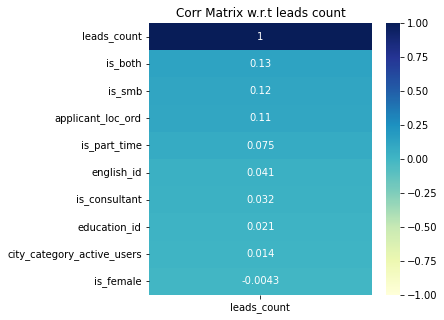

In [500]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(df_wo_outliers.corr()[["leads_count"]].sort_values('leads_count').tail(10),
 vmax=1, vmin=-1, cmap="YlGnBu", annot=True, ax=ax);
ax.invert_yaxis()
plt.title("Corr Matrix w.r.t leads count")

Text(0.5, 1.0, 'Corr Matrix w.r.t leads count')

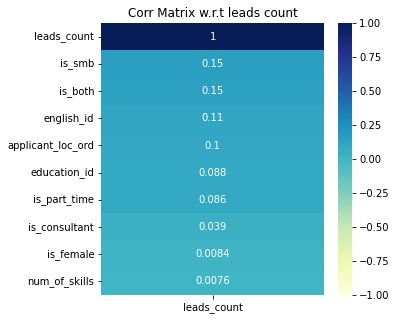

In [501]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(df_wo_outliers.corr("spearman")[["leads_count"]].sort_values('leads_count').tail(10),
 vmax=1, vmin=-1, cmap="YlGnBu", annot=True, ax=ax);
ax.invert_yaxis()
plt.title("Corr Matrix w.r.t leads count")

In [502]:
sub_data = df_wo_outliers[["city_id","city_category_active_users", "leads_count", "category_id"]]

In [503]:
sub_data.sort_values(by="leads_count", ascending=False)
# sub_data[sub_data["leads_count"]>=250].count()

city_id  city_category_active_users  leads_count category_id
84869        1                      117024          143           3
162434      40                        6458          143          29
163329       3                      144021          143           7
59192        4                       20896          143          33
115744      18                       10370          143          30
...        ...                         ...          ...         ...
122517      10                        5874            1          11
47522       18                        9174            1          11
122526       4                       24404            1          30
161071       4                       24689            1          11
84201       11                       18807            1          11

[169052 rows x 4 columns]

In [504]:
sub_data[sub_data["city_id"]==3]

city_id  city_category_active_users  leads_count category_id
230          3                       44900           17          12
234          3                      128540            1          37
237          3                       79058           19          30
238          3                       79058           19          30
240          3                       28849           49          10
...        ...                         ...          ...         ...
176990       3                       44900           28          12
177004       3                      128540            9          37
177008       3                      144021           42           7
177010       3                       79058           32          30
177019       3                       79058           16          30

[32608 rows x 4 columns]

In [505]:
grouped_results = df.groupby(by=["city_id", "category_id"]).agg({'leads_count': ["mean"]})
grouped_results = grouped_results.reset_index()
grouped_results[grouped_results["city_id"]==66]

city_id category_id leads_count
                                mean
3876      66           1         NaN
3877      66           2         NaN
3878      66           3  154.000000
3879      66           4         NaN
3880      66           5   17.700000
3881      66           7         NaN
3882      66           8         NaN
3883      66           9         NaN
3884      66          10         NaN
3885      66          11   80.000000
3886      66          12         NaN
3887      66          13  182.000000
3888      66          15         NaN
3889      66          16         NaN
3890      66          17         NaN
3891      66          18         NaN
3892      66          19   23.000000
3893      66          20         NaN
3894      66          21         NaN
3895      66          22         NaN
3896      66          23         NaN
3897      66          24         NaN
3898      66          25         NaN
3899      66          26         NaN
3900      66          27         NaN
3901      66          28         NaN
3902      66          29   10.000000
3903      66          30   53.733333
3904      66          32         NaN
3905      66          33         NaN
3906      66          34         NaN
3907      66          35         NaN
3908      66          36   38.500000
3909      66          37  314.000000
3910      66          38         NaN
3911      66          39         NaN
3912      66          41         NaN
3913      66          42         NaN
3914      66          43         NaN
3915      66          44         NaN
3916      66          45         NaN
3917      66          46         NaN
3918      66          47         NaN
3919      66          48         NaN
3920      66          51         NaN
3921      66          52   24.833333
3922      66          54         NaN
3923      66          55         NaN
3924      66          56         NaN
3925      66          57         NaN
3926      66          58         NaN
3927      66          60         NaN
3928      66          61         NaN
3929      66          62         NaN
3930      66          63         NaN
3931      66          64         NaN
3932      66          65         NaN
3933      66        1009         NaN
3934      66        1010         NaN
3935      66        1011         NaN
3936      66        1012         NaN
3937      66        1013         NaN
3938      66        1014         NaN
3939      66        1015         NaN
3940      66        1016         NaN
3941      66        1038         NaN
3942      66        1039         NaN
3943      66        1040         NaN

In [506]:
city_category_past_14_active["22"]["55"]

4358

In [507]:
df.city_category_active_users

0         117024
1           3194
2          64334
3          81290
4          19485
           ...  
177015     18355
177016      8712
177017     18355
177018     14969
177019     79058
Name: city_category_active_users, Length: 177019, dtype: int64

In [508]:
df_wo_outliers[(df_wo_outliers["category_id"]==5) & (df_wo_outliers["city_id"]==66)]

job_id                         organization city_id                   area category_id  english_id  education_id  experience_level_id  leads_count applicant_location  applicant_loc_ord  max_salary  min_salary  is_deposit  num_of_skills  num_of_asset shift  is_part_time  is_male  is_female  is_both  num_openings  is_smb  is_keyaccount  is_consultant  is_enterprise                       job_title leads_class  city_category_active_users  mean_salary
46315   111013354           Global Scholars Foundation      66   Solapur-Pune Highway           5           4             5                    2           17          SAME_CITY                  4       75000       25000           0              1             3   day             1        0          0        1             5       1              0              0              0   Customer Relationship Manager           1                         706        50000
58275   193341250                               Byju's      66  Solapur Tuljapur Road           5           3             5                    1           58          SAME_CITY                  4       25000       21000           0              0             0   day             0        0          0        1            50       0              0              0              1  Business Development Executive           4                         706        23000
63708   231010836           Global Scholars Foundation      66                  Mohol           5           3             5                    2           16          SAME_CITY                  4       60000       30000           0              1             2   day             1        0          0        1             5       1              0              0              0        Public Relations Manager           1                         706        45000
69029   268257558           crewbane solution pvt.ltd.      66  Solapur Tuljapur Road           5           1             5                    2            9          SAME_CITY                  4       28000       22000           0              0             2   day             0        1          0        0            50       0              0              1              0  Business Development Executive           0                         706        25000
90706   416639560          Tophawks Marketing Solution      66               Akkalkot           5           3             5                    1           10          SAME_CITY                  4       21000       18000           0              0             0   day             0        0          0        1            50       0              0              0              1  Business Development Executive           0                         706        19500
97310   462855827           SM Nida Manpower Solutions      66            Amrut Nagar           5           4             5                    2           24          SAME_CITY                  4       45000       22000           0              0             1   day             0        0          0        1           250       0              1              0              0          Inside Sales Executive           2                         706        33500
108432  538459749                         Bluecrest Hr      66                 Barshi           5           1             2                    2            2          SAME_CITY                  4       18000       13000           0              3             2   day             0        1          0        0            10       0              0              1              0  Business Development Executive           0                         706        15500
120278  620824857                               Byju's      66           Aditya Nagar           5           3             5                    1           12          SAME_CITY                  4       23000       15000           0              0             0   day             0        0          0        1      

array([<AxesSubplot:ylabel='Frequency'>], dtype=object)

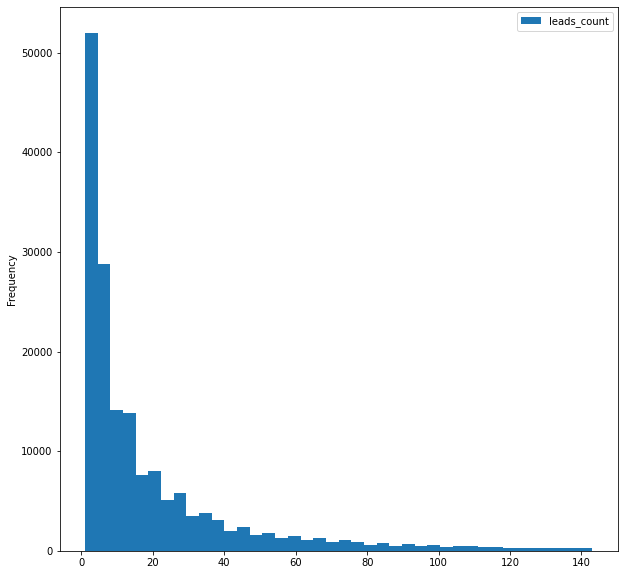

In [509]:
sub_data[["leads_count"]].plot(kind='hist', subplots=True, figsize=(10,10), bins=40)

In [510]:
sub_data[["city_category_active_users"]].plot(kind='hist', subplots=True, figsize=(10,10), bins=40)

array([<AxesSubplot:ylabel='Frequency'>], dtype=object)

In [511]:
df_wo_outliers[df_wo_outliers["city_category_active_users"]<=50][["city_category_active_users", "leads_count"]]

city_category_active_users  leads_count
41269                           48           16
52576                           45            1
54278                           45            3
76511                            0            2
104381                          48            1
107225                          36            8
130860                          48            2
176857                          48            1

In [514]:
df[(df["leads_count"]>500) & (df["city_category_active_users"]<10000)].sort_values(by="leads_count", ascending=False)


job_id                                  organization city_id                                   area category_id  english_id  education_id  experience_level_id  leads_count applicant_location  applicant_loc_ord  max_salary  min_salary  is_deposit  num_of_skills  num_of_asset  shift  is_part_time  is_male  is_female  is_both  num_openings  is_smb  is_keyaccount  is_consultant  is_enterprise                         job_title leads_class  city_category_active_users  mean_salary
31988    14496214                         Nordic intel solution      54                                 Sakchi          37           1             2                    1         4290           ANYWHERE                  5       30000       15000           0              0             2    day             0        0          0        1           250       1              0              0              0           Customer Care Executive           9                        5828        22500
170720  962050823                     Winnosign Private Limited      41                       Medical College           35           3             2                    1         3990           ANYWHERE                  5       50000       20000           0              2             1    day             0        0          0        1            20       1              0              0              0                    Online Teacher           9                        2264        35000
155731  863166958                             Kamakhya Services      60                         Mussoorie Road           7           1             2                    1         2798           ANYWHERE                  5       24000       18000           0              2             2    day             0        0          0        1            23       0              0              1              0                 Computer Operator           9                        7577        21000
146012  796407716                         Nordic Intel solution      54                                 Sakchi          37           1             2                    1         2576           ANYWHERE                  5       28000       15000           0              0             2    day             0        0          0        1           150       1              0              0              0           Customer Care Executive           9                        5828        21500
53405   159772455                         PLAXONIC TECHNOLOGIES      37                  City Centre Extension          37           1             2                    1         2178           ANYWHERE                  5       30000       15000           0              0             0    day             0        0          0        1            30       1              0              0              0                Telecaller Inbound           9                        8135        22500
87748   396181528                                  TELESOLUCION      53                               Jabalpur          37           1             2                    1         1986           ANYWHERE                  5       28000       14000           0              0             0    day             0        0          0        1            30       1              0              0              0        Customer Support Executive           9                        7582        21000
39764    67068013                                ALAC SOLUTIONS      30                           Daba Gardens          37           1             2                    1         1672           ANYWHERE                  5       34000       18000           0              0             0    day             0        0          0        1            40       1              0              0              0                Telecaller Inbound           9                        8604        26000
143971  783204372                             AXCIM ENTERPRISES      29                    

<AxesSubplot:title={'center':'Applicant Distribution Frequency Plot'}>

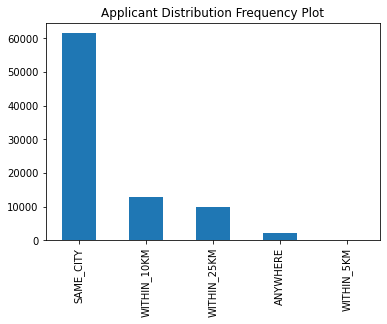

In [515]:
df[df["leads_count"]>10].applicant_location.value_counts().plot(kind='bar', title="Applicant Distribution Frequency Plot")




In [516]:
df_wo_outliers.count()

job_id                        169052
organization                  169052
city_id                       169052
area                          169052
category_id                   169052
english_id                    169052
education_id                  169052
experience_level_id           169052
leads_count                   169052
applicant_location            169052
applicant_loc_ord             169052
max_salary                    169052
min_salary                    169052
is_deposit                    169052
num_of_skills                 169052
num_of_asset                  169052
shift                         169052
is_part_time                  169052
is_male                       169052
is_female                     169052
is_both                       169052
num_openings                  169052
is_smb                        169052
is_keyaccount                 169052
is_consultant                 169052
is_enterprise                 169052
job_title                     169052
l

In [517]:
df_wo_outliers.dtypes

job_id                        category
organization                  category
city_id                       category
area                          category
category_id                   category
english_id                       int64
education_id                     int64
experience_level_id              int64
leads_count                      int64
applicant_location            category
applicant_loc_ord                int64
max_salary                       int64
min_salary                       int64
is_deposit                       int64
num_of_skills                    int64
num_of_asset                     int64
shift                         category
is_part_time                     int64
is_male                          int64
is_female                        int64
is_both                          int64
num_openings                     int64
is_smb                           int64
is_keyaccount                    int64
is_consultant                    int64
is_enterprise            

### Model Training

In [519]:

# '1:' due to index as first column
continuous_columns = list(df.select_dtypes("int").columns)
continuous_columns

['english_id',
 'education_id',
 'experience_level_id',
 'leads_count',
 'applicant_loc_ord',
 'max_salary',
 'min_salary',
 'is_deposit',
 'num_of_skills',
 'num_of_asset',
 'is_part_time',
 'is_male',
 'is_female',
 'is_both',
 'num_openings',
 'is_smb',
 'is_keyaccount',
 'is_consultant',
 'is_enterprise',
 'city_category_active_users',
 'mean_salary']

In [581]:
vars_not_to_use = ["leads_count", "min_salary", "max_salary", "num_openings"]
train_continuous_features = set(continuous_columns) - set(vars_not_to_use)
train_continuous_features

{'applicant_loc_ord',
 'city_category_active_users',
 'education_id',
 'english_id',
 'experience_level_id',
 'is_both',
 'is_consultant',
 'is_deposit',
 'is_enterprise',
 'is_female',
 'is_keyaccount',
 'is_male',
 'is_part_time',
 'is_smb',
 'mean_salary',
 'num_of_asset',
 'num_of_skills'}

In [582]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor, XGBClassifier

x_wo_outliers = df[df["leads_count"] < outlier_dict["leads_count"]["outlier_threshold"]][train_continuous_features]
x_wo_outliers.head()


city_category_active_users  num_of_skills  applicant_loc_ord  is_both  num_of_asset  is_female  mean_salary  experience_level_id  is_keyaccount  is_part_time  is_smb  education_id  is_consultant  is_male  english_id  is_deposit  is_enterprise
0                      117024              5                  2        0             1          1         9500                    2              0             0       1             2              0        0           4           0              0
1                        3194              0                  4        0             0          0        13500                    1              0             0       0             1              0        1           0           0              1
2                       64334              0                  2        0             0          1        15000                    2              0             0       1             5              0        0           3           0              0
3                       81290              0                  3        0             0          1         9000                    2              0             0       0             2              0        0           3           0              1
4                       19485              0                  4        1             0          0        13000                    2              0             0       1             1              0        0           0           0              0

In [583]:
y_class_wo_outliers = df[df["leads_count"] < outlier_dict["leads_count"]["outlier_threshold"]]["leads_class"] 
y_reg_wo_outliers = df[df["leads_count"] < outlier_dict["leads_count"]["outlier_threshold"]]["leads_count"]

In [584]:
x_train_interim, x_test, y_train_interim, y_test = train_test_split(x_wo_outliers, y_class_wo_outliers, test_size=0.2)

x_train, x_eval, y_train, y_eval = train_test_split(x_train_interim, y_train_interim, test_size=0.2)

x_train.head(), y_train.head()

(        city_category_active_users  num_of_skills  applicant_loc_ord  is_both  num_of_asset  is_female  mean_salary  experience_level_id  is_keyaccount  is_part_time  is_smb  education_id  is_consultant  is_male  english_id  is_deposit  is_enterprise
 4768                         53877              4                  2        1             3          0        18000                    2              1             0       0             5              0        0           4           0              0
 116821                       22106              0                  4        1             2          0         5750                    2              1             1       0             2              0        0           1           0              0
 53                           38553              0                  4        1             0          0        20000                    1              0             0       1             2              0        0           3           0        

In [585]:
param = {}

model = XGBClassifier(n_estimators=1000)
eval_set = [(x_eval, y_eval)]

model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=eval_set, verbose=True)

[12:44:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.67846
[1]	validation_0-mlogloss:1.55208
[2]	validation_0-mlogloss:1.47219
[3]	validation_0-mlogloss:1.41837
[4]	validation_0-mlogloss:1.38200
[5]	validation_0-mlogloss:1.35600
[6]	validation_0-mlogloss:1.33463
[7]	validation_0-mlogloss:1.32013
[8]	validation_0-mlogloss:1.30962
[9]	validation_0-mlogloss:1.29779
[10]	validation_0-mlogloss:1.29025
[11]	validation_0-mlogloss:1.28300
[12]	validation_0-mlogloss:1.27806
[13]	validation_0-mlogloss:1.27194
[14]	validation_0-mlogloss:1.26639
[15]	validation_0-mlogloss:1.26327
[16]	validation_0-mlogloss:1.26012
[17]	validation_0-mlogloss:1.25675
[18]	validation_0-mlogloss:1.25102
[19]	validation_0-mlogloss:1.24731
[20]	validation_0-mlogloss:1.24512
[21]	validation_0-mlog

[224]	validation_0-mlogloss:1.13114
[225]	validation_0-mlogloss:1.13101
[226]	validation_0-mlogloss:1.13081
[227]	validation_0-mlogloss:1.13059
[228]	validation_0-mlogloss:1.13041
[229]	validation_0-mlogloss:1.13050
[230]	validation_0-mlogloss:1.13045
[231]	validation_0-mlogloss:1.13055
[232]	validation_0-mlogloss:1.13030
[233]	validation_0-mlogloss:1.13031
[234]	validation_0-mlogloss:1.13016
[235]	validation_0-mlogloss:1.13003
[236]	validation_0-mlogloss:1.13002
[237]	validation_0-mlogloss:1.12992
[238]	validation_0-mlogloss:1.12974
[239]	validation_0-mlogloss:1.12955
[240]	validation_0-mlogloss:1.12965
[241]	validation_0-mlogloss:1.12941
[242]	validation_0-mlogloss:1.12932
[243]	validation_0-mlogloss:1.12929
[244]	validation_0-mlogloss:1.12934
[245]	validation_0-mlogloss:1.12928
[246]	validation_0-mlogloss:1.12924
[247]	validation_0-mlogloss:1.12916
[248]	validation_0-mlogloss:1.12899
[249]	validation_0-mlogloss:1.12902
[250]	validation_0-mlogloss:1.12889
[251]	validation_0-mlogloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [586]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


In [587]:
from sklearn.metrics import classification_report

print (classification_report(list(y_test), list(model.predict(x_test))))

              precision    recall  f1-score   support

           0       0.70      0.93      0.80     18171
           1       0.30      0.21      0.25      6050
           2       0.21      0.07      0.11      3101
           3       0.26      0.20      0.23      3005
           4       0.27      0.15      0.19      1779
           5       0.19      0.06      0.10       888
           6       0.28      0.14      0.18       804

    accuracy                           0.58     33798
   macro avg       0.31      0.25      0.27     33798
weighted avg       0.50      0.58      0.52     33798



In [588]:
feature_importances = list(zip(train_continuous_features, model.feature_importances_))
feature_importances.sort(key=lambda x:x[1], reverse=True)
print (*feature_importances, sep='\n')

('experience_level_id', 0.09833118)
('num_of_asset', 0.09612446)
('is_deposit', 0.07436427)
('is_enterprise', 0.069860294)
('is_part_time', 0.068204306)
('city_category_active_users', 0.0669633)
('is_both', 0.06553947)
('education_id', 0.05754746)
('is_smb', 0.05538507)
('applicant_loc_ord', 0.053772315)
('is_female', 0.05170648)
('english_id', 0.04823593)
('is_male', 0.041773014)
('is_keyaccount', 0.041528493)
('mean_salary', 0.039165203)
('num_of_skills', 0.03601867)
('is_consultant', 0.035480045)


In [589]:
x_train_interim, x_test, y_train_interim, y_test = train_test_split(x_wo_outliers, y_reg_wo_outliers, test_size=0.2)

x_train, x_eval, y_train, y_eval = train_test_split(x_train_interim, y_train_interim, test_size=0.2)

x_train.head(), y_train.head()

(        city_category_active_users  num_of_skills  applicant_loc_ord  is_both  num_of_asset  is_female  mean_salary  experience_level_id  is_keyaccount  is_part_time  is_smb  education_id  is_consultant  is_male  english_id  is_deposit  is_enterprise
 91810                         2943              0                  4        0             5          0        25000                    1              0             0       0             1              1        1           0           0              0
 36511                         2250              0                  4        1             3          0        14500                    1              1             0       0             5              0        0           4           0              0
 143820                       24918              0                  4        1             0          0        27500                    2              0             0       1             5              0        0           3           0        

In [590]:
model = XGBRegressor(n_estimators=1000)
eval_set = [(x_eval, y_eval)]

model.fit(x_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:27.19680
[1]	validation_0-rmse:25.11507
[2]	validation_0-rmse:23.91388
[3]	validation_0-rmse:23.19607
[4]	validation_0-rmse:22.73849
[5]	validation_0-rmse:22.47411
[6]	validation_0-rmse:22.29254
[7]	validation_0-rmse:22.07251
[8]	validation_0-rmse:21.97983
[9]	validation_0-rmse:21.88532
[10]	validation_0-rmse:21.79099
[11]	validation_0-rmse:21.72577
[12]	validation_0-rmse:21.51089
[13]	validation_0-rmse:21.33607
[14]	validation_0-rmse:21.28571
[15]	validation_0-rmse:21.24605
[16]	validation_0-rmse:21.12902
[17]	validation_0-rmse:21.08324
[18]	validation_0-rmse:21.03807
[19]	validation_0-rmse:20.97802
[20]	validation_0-rmse:20.94370
[21]	validation_0-rmse:20.90229
[22]	validation_0-rmse:20.80744
[23]	validation_0-rmse:20.69035
[24]	validation_0-rmse:20.62417
[25]	validation_0-rmse:20.60336
[26]	validation_0-rmse:20.55733
[27]	validation_0-rmse:20.49022
[28]	validation_0-rmse:20.45061
[29]	validation_0-rmse:20.40379
[30]	validation_0-rmse:20.32116
[31]	validation_0-

[252]	validation_0-rmse:17.95172
[253]	validation_0-rmse:17.93584
[254]	validation_0-rmse:17.93573
[255]	validation_0-rmse:17.93391
[256]	validation_0-rmse:17.93177
[257]	validation_0-rmse:17.92731
[258]	validation_0-rmse:17.92728
[259]	validation_0-rmse:17.92577
[260]	validation_0-rmse:17.92594
[261]	validation_0-rmse:17.92498
[262]	validation_0-rmse:17.92452
[263]	validation_0-rmse:17.92115
[264]	validation_0-rmse:17.92070
[265]	validation_0-rmse:17.91180
[266]	validation_0-rmse:17.90973
[267]	validation_0-rmse:17.90803
[268]	validation_0-rmse:17.90027
[269]	validation_0-rmse:17.89751
[270]	validation_0-rmse:17.89752
[271]	validation_0-rmse:17.89632
[272]	validation_0-rmse:17.89583
[273]	validation_0-rmse:17.88863
[274]	validation_0-rmse:17.88879
[275]	validation_0-rmse:17.88675
[276]	validation_0-rmse:17.88556
[277]	validation_0-rmse:17.88672
[278]	validation_0-rmse:17.88475
[279]	validation_0-rmse:17.87677
[280]	validation_0-rmse:17.87805
[281]	validation_0-rmse:17.87409
[282]	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [591]:
from sklearn.metrics import r2_score

print (r2_score(list(y_test), list(model.predict(x_test))))

0.5046729849673134


In [592]:
feature_importances = list(zip(train_continuous_features, model.feature_importances_))
feature_importances.sort(key=lambda x:x[1], reverse=True)
print (*feature_importances, sep='\n')

('experience_level_id', 0.10426198)
('num_of_asset', 0.08194188)
('is_both', 0.07250025)
('city_category_active_users', 0.07230788)
('education_id', 0.071002424)
('is_enterprise', 0.07092156)
('applicant_loc_ord', 0.067800805)
('is_part_time', 0.06239249)
('is_smb', 0.061874017)
('is_female', 0.058745064)
('is_deposit', 0.054155555)
('english_id', 0.053238682)
('is_keyaccount', 0.037336368)
('mean_salary', 0.03533464)
('is_male', 0.033594668)
('num_of_skills', 0.03226864)
('is_consultant', 0.030323153)


In [594]:
df["job_id"].nunique(), df["job_id"].count()

(175076, 177019)

In [ ]:
predict_data_query = """
select
 job_id,
 organization,
 city_id,
 area,
 category_id,
 CASE WHEN english = 'No English' THEN 0
       WHEN english = 'Thoda English' THEN 1
       WHEN english = 'Basic English' THEN 2
       WHEN english = 'Good English' THEN 3
       WHEN english = 'Fluent English' THEN 4 END english_id,
 education_id,
 experience_level_id,
 applicant_location,
 max_salary,
 min_salary,
 is_deposit,
 num_of_skills,
 num_of_asset,
 shift,
 is_part_time,
 case when gender is not null then gender else 'both' end gender,
 num_openings,
 leads_count as leads_actual,
 CASE WHEN lead_type = 'smb' then TRUE else FALSE END is_smb,
 CASE WHEN lead_type = 'key-account' then TRUE else FALSE END is_keyaccount,
 CASE WHEN lead_type = 'consultant' then TRUE else FALSE END is_consultant,
 CASE WHEN lead_type = 'enterprise' then TRUE else FALSE END is_enterprise,
 job_title,
  CASE WHEN leads_count between 0 and 10 THEN 0
      WHEN leads_count between 11 and 20 THEN 1
      WHEN leads_count between 21 and 30 THEN 2
      WHEN leads_count between 31 and 50 THEN 3
      WHEN leads_count between 51 and 75 THEN 4
      WHEN leads_count between 76 and 100 THEN 5
      WHEN leads_count between 101 and 150 THEN 6
      WHEN leads_count between 151 and 200 THEN 7
      WHEN leads_count between 201 and 250 THEN 8
      WHEN leads_count > 250 THEN 9 END leads_class_actual
from
(
select distinct
  cja.job_id,
  fr.organization,
  fr.city_id,
  fr.area,
  fr.english,
  fr.education,
  edu.ordered_id as education_id,
  cj.experience_level_id,
  fr.applicant_location,
  fr.max_salary,
  cj.json_data.min_salary min_salary,
  CASE WHEN cj.json_data.deposit IS NOT NULL THEN TRUE ELSE FALSE END is_deposit,
  count(distinct ct_skill.id) over (partition by cj.id) num_of_skills,
  count(distinct ct_asset.id) over (partition by cj.id) num_of_asset,
  fr.shift,
  fr.is_part_time,
  fr.gender,
  fr.lead_type,
  fr.category_id,
  cj.title job_title,
  fr.num_openings,
  count(distinct CASE WHEN cja.lead_created_at IS NOT NULL THEN cja.user_id END) OVER (partition by cja.job_id) leads_count
from
  `apnatime-fbc72.dataset_postgres_production.core_job` cj,
  `apnatime-fbc72.dataset_postgres_production.core_jobapplications` cja,
  (
  select * from
  (
  select distinct *,
  ROW_NUMBER() OVER (PARTITION BY JOB_ID,date(effective_activated_at) ORDER BY createdAt desc ) row_num
  from `apnatime-fbc72.dataset_production.fulfillment_report`
  where date("2022-01-18") between date(effective_activated_at) and date(expiry)
  ) where row_num = 1) fr
  left outer join `apnatime-fbc72.dataset_postgres_production.core_job_tags` cjt on cj.id = cjt.job_id
  left outer join `apnatime-fbc72.dataset_postgres_production.core_tag` ct_skill on cjt.tag_id = ct_skill.id and ct_skill.tag_type = 'skill'
  left outer join `apnatime-fbc72.dataset_postgres_production.core_tag` ct_asset on cjt.tag_id = ct_asset.id and ct_asset.tag_type = 'asset'
  left outer join `apnatime-fbc72.dataset_postgres_production.core_educationlevels` edu on edu.level = fr.education

WHERE fr.job_id = cj.id
and cj.id = cja.job_id
and cja.lead_created_at IS NOT NULL
and date(cja.lead_created_at) between date(fr.effective_activated_at) and date(date(fr.effective_activated_at) + 14)
)
"""